0ptimisation de f1 score via GridSearch

# Imports

In [55]:
#pip install xgboost

In [57]:
#pip install imblearn

In [58]:
#pip install --upgrade pip

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid, cross_validate

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score, classification_report
from sklearn.metrics import fbeta_score

from collections import Counter

from math import sqrt

import pickle

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_style("whitegrid")

# Data

In [2]:
dfdata = pd.read_csv('data.csv')

In [3]:
dfdata.shape

(307511, 245)

## Train, test, validation sets

In [4]:
X = dfdata.copy()
X = X.drop(columns = ['TARGET'])
y = dfdata['TARGET']

In [5]:
#création d'un jeu d'entrainement et d'un jeu de test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

#création d'un jeu de validation à partir du jeu d'entrainement
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size = 0.25, stratify = y_train_temp)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(184506, 244)
(184506,)
(61503, 244)
(61503,)
(61502, 244)
(61502,)


Text(0.5, 1.0, 'validation set class distribution')

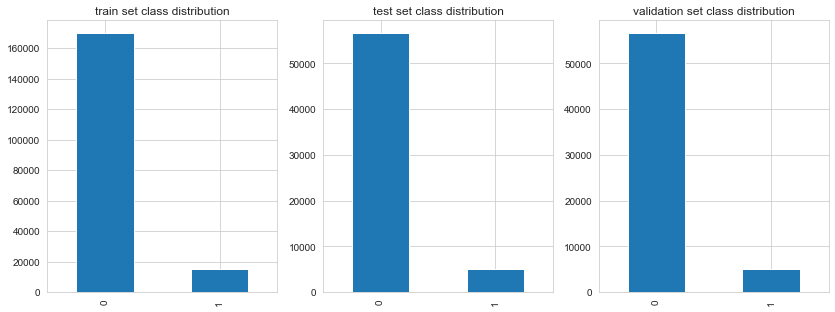

In [10]:
fig = plt.figure(figsize=(14,5))

plt.subplot(131)
y_train.value_counts().plot(kind = 'bar')
plt.title('train set class distribution')

plt.subplot(132)
y_test.value_counts().plot(kind = 'bar')
plt.title('test set class distribution')

plt.subplot(133)
y_val.value_counts().plot(kind = 'bar')
plt.title('validation set class distribution')

In [11]:
print('Class 0:', y_train.value_counts()[0])
print('Class 0:', y_train.value_counts()[1])
print('Proportion: {}%'.format(round(y_train.value_counts()[0] / y_train.value_counts()[1], 2)))

Class 0: 169611
Class 0: 14895
Proportion: 11.39%


## Imputation

Les valeurs manquantes sont imputées par la valeur médiane sur le jeu d'entrainement, puis sur les jeux de validation et de test.

In [8]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
df_missing_value_train = missing_values_table(X_train)
df_missing_value_train.head(10)

Your selected dataframe has 244 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,128982,69.9
COMMONAREA_MODE,128982,69.9
COMMONAREA_MEDI,128982,69.9
NONLIVINGAPARTMENTS_MODE,128118,69.4
NONLIVINGAPARTMENTS_MEDI,128118,69.4
NONLIVINGAPARTMENTS_AVG,128118,69.4
LIVINGAPARTMENTS_MEDI,126145,68.4
LIVINGAPARTMENTS_MODE,126145,68.4
LIVINGAPARTMENTS_AVG,126145,68.4
FLOORSMIN_AVG,125213,67.9


In [10]:
df_missing_value_test = missing_values_table(X_test)
df_missing_value_test.head(10)

Your selected dataframe has 244 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,42870,69.7
COMMONAREA_MEDI,42870,69.7
COMMONAREA_AVG,42870,69.7
NONLIVINGAPARTMENTS_AVG,42580,69.2
NONLIVINGAPARTMENTS_MEDI,42580,69.2
NONLIVINGAPARTMENTS_MODE,42580,69.2
LIVINGAPARTMENTS_MODE,41911,68.1
LIVINGAPARTMENTS_MEDI,41911,68.1
LIVINGAPARTMENTS_AVG,41911,68.1
FLOORSMIN_AVG,41604,67.6


In [11]:
df_missing_value_val = missing_values_table(X_val)
df_missing_value_val.head(10)

Your selected dataframe has 244 columns.
There are 63 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,43013,69.9
COMMONAREA_MEDI,43013,69.9
COMMONAREA_MODE,43013,69.9
NONLIVINGAPARTMENTS_MODE,42816,69.6
NONLIVINGAPARTMENTS_MEDI,42816,69.6
NONLIVINGAPARTMENTS_AVG,42816,69.6
LIVINGAPARTMENTS_MODE,42143,68.5
LIVINGAPARTMENTS_AVG,42143,68.5
LIVINGAPARTMENTS_MEDI,42143,68.5
FLOORSMIN_MODE,41825,68.0


In [12]:
#Imputation des valeurs manquantes par la valeur médiane

imputer = SimpleImputer(strategy = 'median')
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)
X_val = imputer.transform(X_val)

In [13]:
X_train2 = pd.DataFrame(X_train)
df_missing_value_train2 = missing_values_table(X_train2)

Your selected dataframe has 244 columns.
There are 0 columns that have missing values.


In [14]:
X_test2 = pd.DataFrame(X_val)
df_missing_value_test2 = missing_values_table(X_test2)

Your selected dataframe has 244 columns.
There are 0 columns that have missing values.


In [15]:
X_val2 = pd.DataFrame(X_val)
df_missing_value_val2 = missing_values_table(X_val2)

Your selected dataframe has 244 columns.
There are 0 columns that have missing values.


## init scores summary & model_dict

In [56]:
#pour stocker les cores et paramètres des modèles
df_scores = pd.DataFrame(columns=['recall','precision','f1_score', 'TP','confusion_matrix', 'threshold', 'best_param'])

In [57]:
#pour stocker les modèles
dict_models = {}

In [67]:
#pour stocker le scaler
dict_scaler = {}

# Problematic and metrics

Soit 0, la classe sans défaut de paiement. 
Soit 1, la classe avec défaut de paiement.

Il s'agit ici de minimiser les faux négatifs, c'est à dire les personnes prédites comme étant sans défaut de paiement et qui pourtant présentent un défaut de paiement. Il va donc s'agir __d'optimiser le recall__.
Toutefois, en maximisant uniquement le recall, le risque est d'augmenter significativement le nombre de personnes sans défaut de paiement prédites comme étant en défaut (faux positifs).  
__Le f1-score__ intègre ces 2 métriques.  
  
Recall = TP/ (TP+FN) : nb de personnes prédites en défaut/ nb de personnes total réellement en défaut  
Precision = TP/ (TP+FP) : nb de personnes prédites en défaut et réellement en défaut/ nb de personnes totales prédites en défaut  
f1_score = 2(Precision*Recall)/(Precision+Recall) 


# Integration of uncertainty

Prise en compte de l'incertitude  
La matrice de confusion et le rapport de classification fournissent une analyse détaillée pour un jeu de données particulier de prédiction. Cependant, les prédictions elles-même éliminent certaines informations qui sont contenues dans le modèle. La méthode __predict_proba__ permet d'évaluer les degrés de certitude sur les prédictions. Ainsi, faire des prédictions peut être vu comme un seuillage de la sortie produite par predict_proba en un certain point fixé. Dans la classification binaire, on utilise 0.5.   
S'il est plus important d'avoir un rappel élevé pour la class 1, cela implique que nous acceptons de risquer davantage de faux positifs (faux class 1) en échange de plus de vrais positifs (ce qui augmente le rappel).  
Pour les modèles qui implémentent la méthode predict_proba, par défaut, la valeur de seuil de 0.5, signifie que si le modèle est sûr à plus de 50% qu'un point est dans la classe positive, alors il est classifié comme tel. Augmenter la valeur du seuil signifie que le modèle a besoin d'améliorer son taux de certitude pour prendre une décision positive.  

# Train model

## baseline

In [21]:
#recalibrage des datasets

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

### XGBClassifier

In [22]:
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train)

y_pred_xgb = xgb.predict(X_val_scaled)

cm_xgb = confusion_matrix(y_val, y_pred_xgb)
print(cm_xgb)
print(classification_report(y_val, y_pred_xgb))

[[56508    29]
 [ 4928    37]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       0.56      0.01      0.01      4965

    accuracy                           0.92     61502
   macro avg       0.74      0.50      0.49     61502
weighted avg       0.89      0.92      0.88     61502



#### threshold

best threshold: 0.15
best f1_score: 0.30


Text(0.5, 1.0, 'Evolution du f1_score en fonction du seuil de probabilité')

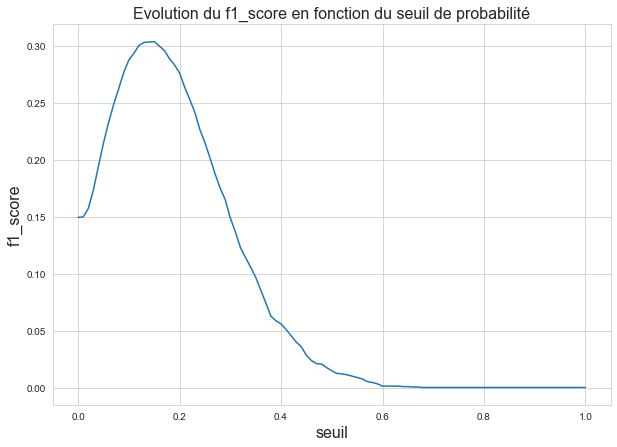

In [23]:
list_f1_score = []
y_pred_proba = xgb.predict_proba(X_val_scaled)
for i in np.arange(0, 1.01, 0.01):
    y_pred_th = (y_pred_proba[:,1] >= i).astype(bool)
    f1score = f1_score(y_val, y_pred_th)
    list_f1_score.append(f1score)
    
for i, j in enumerate(list_f1_score):
    if j == max(list_f1_score):
        best_threshold = i/100
        best_f1score = j
        print("best threshold:", best_threshold)    
        print("best f1_score: {:.2f}".format(best_f1score))

plt.figure(figsize=(10,7))
plt.plot(list(np.arange(0, 1.01, 0.01)), list_f1_score)
plt.xlabel('seuil', fontsize = 16)
plt.ylabel('f1_score', fontsize = 16)
plt.title('Evolution du f1_score en fonction du seuil de probabilité', fontsize = 16)

In [24]:
y_pred_th_best = (y_pred_proba[:,1] >= best_threshold).astype(bool)

cm_xgb = confusion_matrix(y_val, y_pred_th_best)
print(cm_xgb)
print(classification_report(y_val, y_pred_th_best))

[[50641  5896]
 [ 3020  1945]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     56537
           1       0.25      0.39      0.30      4965

    accuracy                           0.86     61502
   macro avg       0.60      0.64      0.61     61502
weighted avg       0.89      0.86      0.87     61502



### XGBClassifier GridSearch

In [58]:
#création d'une grille d'hyperparamètres

parameters = {"n_estimators" : [200, 400],
              "learning_rate" : [1],
              "max_depth" : [3, 6, 10]}

param_grid = ParameterGrid(parameters)

In [59]:
#gridsearch

import time
print("Début de l'optimisation des paramètres:")
print('{} configurations à traiter'.format(len(param_grid)))
now = time.asctime()
print(now, '\n')

best_score = 0
best_recall = 0
best_precision = 0
best_model = None
best_parameters = None
best_pred = None
best_cm = None
count = 0

for parameter in param_grid:
    
    xgb = XGBClassifier(n_estimators = parameter['n_estimators'],
                        learning_rate = parameter['learning_rate'],
                        max_depth=parameter['max_depth'])
   
    xgb.fit(X_train_scaled, y_train)
    
    y_pred = xgb.predict(X_val_scaled)
    
    f1score = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    if f1score > best_score:
        best_score = f1score
        best_recall = recall
        best_precision = precision
        best_model = xgb
        best_parameters = parameter
        best_pred = y_pred
        best_cm = cm
    
    print('étape {} terminée'.format(count))
    now = time.asctime()
    print('paramètres:',parameter)
    print('recall', recall)
    print('precision', precision)
    print('f1score:', f1score)
    print(cm)
    print(now,'\n')
    
    
    count += 1    

Début de l'optimisation des paramètres:
6 configurations à traiter
Wed Jan 13 15:18:01 2021 

étape 0 terminée
paramètres: {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 200}
recall 0.06586102719033232
precision 0.34935897435897434
f1score: 0.11082867310625318
[[55928   609]
 [ 4638   327]]
Wed Jan 13 15:26:35 2021 

étape 1 terminée
paramètres: {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 400}
recall 0.07411883182275932
precision 0.2944
f1score: 0.11842316975060338
[[55655   882]
 [ 4597   368]]
Wed Jan 13 15:43:30 2021 

étape 2 terminée
paramètres: {'learning_rate': 1, 'max_depth': 6, 'n_estimators': 200}
recall 0.10876132930513595
precision 0.22660511959714646
f1score: 0.14697876973326077
[[54694  1843]
 [ 4425   540]]
Wed Jan 13 15:59:26 2021 

étape 3 terminée
paramètres: {'learning_rate': 1, 'max_depth': 6, 'n_estimators': 400}
recall 0.10916414904330313
precision 0.22433774834437087
f1score: 0.14686356862213792
[[54663  1874]
 [ 4423   542]]
Wed Jan 13 16:30:18 20

In [60]:
df_scores.loc['XGBC', 'recall'] = best_recall
df_scores.loc['XGBC', 'precision'] = best_precision
df_scores.loc['XGBC', 'f1_score'] = best_score
df_scores.loc['XGBC', 'TP'] = best_cm[1][1]
df_scores.loc['XGBC', 'confusion_matrix'] = best_cm
df_scores.loc['XGBC', 'threshold'] = 0.5
df_scores.loc['XGBC', 'best_param'] = str(best_parameters)

In [61]:
df_scores

,recall,precision,f1_score,TP,confusion_matrix,threshold,best_param
XGBC,0.108761,0.226605,0.146979,540,"[[54694, 1843], [4425, 540]]",0.5,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."


In [62]:
dict_models['XGBC'] = best_model

In [68]:
dict_scaler['std_XGBC'] = scaler

best threshold: 0.09
best f1_score: 0.24


Text(0.5, 1.0, 'Evolution du f1_score en fonction du seuil de probabilité')

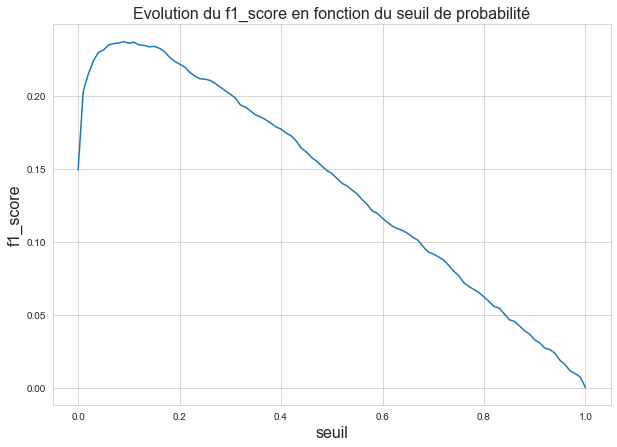

In [70]:
list_f1_score = []
y_pred_proba = best_model.predict_proba(X_val_scaled)
for i in np.arange(0, 1.01, 0.01):
    y_pred_th = (y_pred_proba[:,1] >= i).astype(bool)
    f1score = f1_score(y_val, y_pred_th)
    list_f1_score.append(f1score)
    
for i, j in enumerate(list_f1_score):
    if j == max(list_f1_score):
        best_threshold = i/100
        best_f1score = j
        print("best threshold:", best_threshold)    
        print("best f1_score: {:.2f}".format(best_f1score))

plt.figure(figsize=(10,7))
plt.plot(list(np.arange(0, 1.01, 0.01)), list_f1_score)
plt.xlabel('seuil', fontsize = 16)
plt.ylabel('f1_score', fontsize = 16)
plt.title('Evolution du f1_score en fonction du seuil de probabilité', fontsize = 16)

In [71]:
y_pred_th_best = (y_pred_proba[:,1] >= best_threshold).astype(bool)

best_recall = recall_score(y_val, y_pred_th_best)
best_precision = precision_score(y_val, y_pred_th_best)
best_f1score = f1_score(y_val, y_pred_th_best)
cm_xgb = confusion_matrix(y_val, y_pred_th_best)
print(cm_xgb,'\n')
print(classification_report(y_val, y_pred_th_best))

[[46342 10195]
 [ 2924  2041]] 

              precision    recall  f1-score   support

           0       0.94      0.82      0.88     56537
           1       0.17      0.41      0.24      4965

    accuracy                           0.79     61502
   macro avg       0.55      0.62      0.56     61502
weighted avg       0.88      0.79      0.82     61502



In [72]:
df_scores.loc['XGBC_th', 'recall'] = best_recall
df_scores.loc['XGBC_th', 'precision'] = best_precision
df_scores.loc['XGBC_th', 'f1_score'] = best_f1score
df_scores.loc['XGBC_th', 'TP'] = cm_xgb[1][1]
df_scores.loc['XGBC_th', 'confusion_matrix'] = cm_xgb
df_scores.loc['XGBC_th', 'threshold'] = best_threshold
df_scores.loc['XGBC_th', 'best_param'] = str(best_parameters)

In [73]:
df_scores

,recall,precision,f1_score,TP,confusion_matrix,threshold,best_param
XGBC,0.108761,0.226605,0.146979,540,"[[54694, 1843], [4425, 540]]",0.5,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_th,0.411078,0.166803,0.237312,2041,"[[46342, 10195], [2924, 2041]]",0.09,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."


## Imbalance treatment

Différents traitements peuvent être envisagés pour gérer le déséquilibre des données, parmi lesquels:  
*le rééchantillonnage des données: le sur-échantillonnage et/ou le sous-échantillonnage    
*le cost sensitive learning qui consiste à redéfinirla fonction de coût du modèle en tenant compte des poids (avec par exemple scale-pos-weight pour le boosting)   
*l'ensemble learning: on entraîne différents modèles sur différents jeux de données avec le même ratio des classes rééchantillonné. On moyenne les prédictions des différents modèles.  
*One-Class-Classification: Apprentissage sur un jeud e données ne contenant qu'une classe d'observation. On cherche ensuite à déterminer si la nouvelle observation ressemble à la population sur laquelle le modèle a été entraîné ou peut-être considéré comme un outlier et appartient donc à l'autre classe.

### Resampling

Random under-sampling and over-sampling with imbalanced-learn  
https://www.kaggle.com/tini9911/imbalance-in-data

#### undersampling

In [35]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

In [36]:
y_train.value_counts()

0    169611
1     14895
Name: TARGET, dtype: int64

In [37]:
y_rus.value_counts()

1    14895
0    14895
Name: TARGET, dtype: int64

In [38]:
#recalibrage des datasets

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_rus)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [39]:
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_rus)

XGBClassifier()

In [40]:
y_pred_xgb = xgb.predict(X_val_scaled)

In [41]:
y_pred_xgb.shape

(61502,)

In [42]:
y_val.shape

(61502,)

In [43]:
cm_xgb = confusion_matrix(y_val, y_pred_xgb)
cm_xgb

array([[39145, 17392],
       [ 1531,  3434]])

In [44]:
print(classification_report(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.16      0.69      0.27      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.54     61502
weighted avg       0.90      0.69      0.76     61502



best threshold: 0.66
best f1_score: 0.30


Text(0.5, 1.0, 'Evolution du f1_score en fonction du seuil de probabilité')

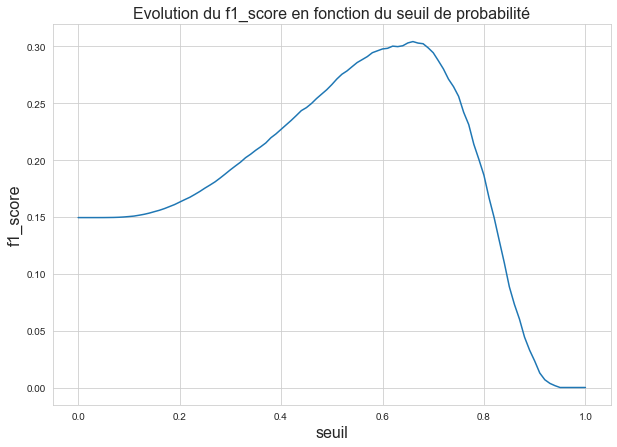

In [45]:
list_f1_score = []
y_pred_proba = xgb.predict_proba(X_val_scaled)
for i in np.arange(0, 1.01, 0.01):
    y_pred_th = (y_pred_proba[:,1] >= i).astype(bool)
    f1score = f1_score(y_val, y_pred_th)
    list_f1_score.append(f1score)
    
for i, j in enumerate(list_f1_score):
    if j == max(list_f1_score):
        best_threshold = i/100
        best_f1score = j
        print("best threshold:", best_threshold)    
        print("best f1_score: {:.2f}".format(best_f1score))

plt.figure(figsize=(10,7))
plt.plot(list(np.arange(0, 1.01, 0.01)), list_f1_score)
plt.xlabel('seuil', fontsize = 16)
plt.ylabel('f1_score', fontsize = 16)
plt.title('Evolution du f1_score en fonction du seuil de probabilité', fontsize = 16)

In [46]:
y_pred_th_best = (y_pred_proba[:,1] >= best_threshold).astype(bool)

cm_xgb = confusion_matrix(y_val, y_pred_th_best)
print(cm_xgb)
print(classification_report(y_val, y_pred_th_best))

[[50641  5896]
 [ 3017  1948]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     56537
           1       0.25      0.39      0.30      4965

    accuracy                           0.86     61502
   macro avg       0.60      0.64      0.61     61502
weighted avg       0.89      0.86      0.87     61502



#### undersampling GridSearch

In [74]:
#création d'une grille d'hyperparamètres

parameters = {"n_estimators" : [200, 400],
              "learning_rate" : [0.1, 1],
              "max_depth" : [3, 6, 10]}

param_grid = ParameterGrid(parameters)

In [75]:
#gridsearch

import time
print("Début de l'optimisation des paramètres:")
print('{} configurations à traiter'.format(len(param_grid)))
now = time.asctime()
print(now, '\n')

best_score = 0
best_recall = 0
best_precision = 0
best_model = None
best_parameters = None
best_pred = None
best_cm = None
count = 0


rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_rus)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


for parameter in param_grid:
    
    xgb = XGBClassifier(n_estimators = parameter['n_estimators'],
                        learning_rate = parameter['learning_rate'],
                        max_depth=parameter['max_depth'])
   
    xgb.fit(X_train_scaled, y_rus)
    
    y_pred = xgb.predict(X_val_scaled)
    
    
    f1score = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    if f1score > best_score:
        best_score = f1score
        best_recall = recall
        best_precision = precision
        best_model = xgb
        best_parameters = parameter
        best_pred = y_pred
        best_cm = cm
    
    print('étape {} terminée'.format(count))
    now = time.asctime()
    print('paramètres:',parameter)
    print('f1score:', f1score)
    print(cm)
    print(now,'\n')
    
    
    count += 1    

Début de l'optimisation des paramètres:
12 configurations à traiter
Wed Jan 13 17:54:09 2021 

étape 0 terminée
paramètres: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
f1score: 0.2683676247520516
[[39241 17296]
 [ 1515  3450]]
Wed Jan 13 17:55:42 2021 

étape 1 terminée
paramètres: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}
f1score: 0.2693518914505657
[[39245 17292]
 [ 1501  3464]]
Wed Jan 13 17:58:43 2021 

étape 2 terminée
paramètres: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
f1score: 0.2689711677265811
[[39318 17219]
 [ 1518  3447]]
Wed Jan 13 18:01:13 2021 

étape 3 terminée
paramètres: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400}
f1score: 0.2675228222187838
[[39108 17429]
 [ 1507  3458]]
Wed Jan 13 18:06:01 2021 

étape 4 terminée
paramètres: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
f1score: 0.2619568135619223
[[38844 17693]
 [ 1550  3415]]
Wed Jan 13 18:09:56 2021 

étape 5 terminée
paramètres: 

In [76]:
df_scores.loc['XGBC_underSampling', 'recall'] = best_recall
df_scores.loc['XGBC_underSampling', 'precision'] = best_precision
df_scores.loc['XGBC_underSampling', 'f1_score'] = best_score
df_scores.loc['XGBC_underSampling', 'TP'] = best_cm[1][1]
df_scores.loc['XGBC_underSampling', 'confusion_matrix'] = best_cm
df_scores.loc['XGBC_underSampling', 'threshold'] = 0.5
df_scores.loc['XGBC_underSampling', 'best_param'] = str(best_parameters)

In [78]:
df_scores

,recall,precision,f1_score,TP,confusion_matrix,threshold,best_param
XGBC,0.108761,0.226605,0.146979,540,"[[54694, 1843], [4425, 540]]",0.5,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_th,0.411078,0.166803,0.237312,2041,"[[46342, 10195], [2924, 2041]]",0.09,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_underSampling,0.697684,0.166892,0.269352,3464,"[[39245, 17292], [1501, 3464]]",0.5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."


In [79]:
dict_models['XGBC_underSampling'] = best_model

In [80]:
dict_scaler['std_XGBC_underSampling'] = scaler

best threshold: 0.69
best f1_score: 0.31


Text(0.5, 1.0, 'Evolution du f1_score en fonction du seuil de probabilité')

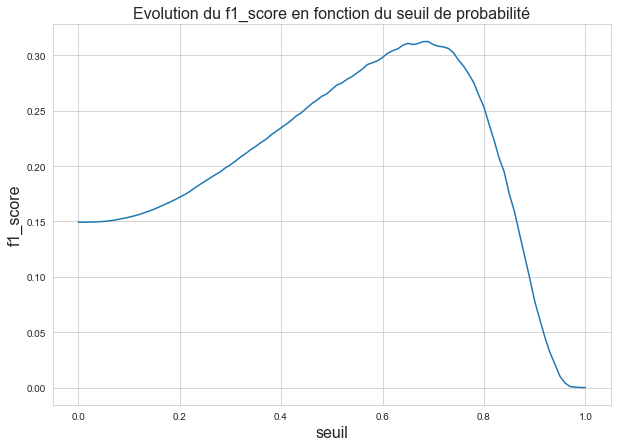

In [81]:
#best f1_score selon le seuil

list_f1_score = []
y_pred_proba = best_model.predict_proba(X_val_scaled)
for i in np.arange(0, 1.01, 0.01):
    y_pred_th = (y_pred_proba[:,1] >= i).astype(bool)
    f1score = f1_score(y_val, y_pred_th)
    list_f1_score.append(f1score)
    
for i, j in enumerate(list_f1_score):
    if j == max(list_f1_score):
        best_threshold = i/100
        best_f1score = j
        print("best threshold:", best_threshold)    
        print("best f1_score: {:.2f}".format(best_f1score))

plt.figure(figsize=(10,7))
plt.plot(list(np.arange(0, 1.01, 0.01)), list_f1_score)
plt.xlabel('seuil', fontsize = 16)
plt.ylabel('f1_score', fontsize = 16)
plt.title('Evolution du f1_score en fonction du seuil de probabilité', fontsize = 16)

In [82]:
y_pred_th_best = (y_pred_proba[:,1] >= best_threshold).astype(bool)

best_recall = recall_score(y_val, y_pred_th_best)
best_precision = precision_score(y_val, y_pred_th_best)
best_f1score = f1_score(y_val, y_pred_th_best)
cm_xgb = confusion_matrix(y_val, y_pred_th_best)
print(cm_xgb,'\n')
print(classification_report(y_val, y_pred_th_best))

[[50581  5956]
 [ 2942  2023]] 

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     56537
           1       0.25      0.41      0.31      4965

    accuracy                           0.86     61502
   macro avg       0.60      0.65      0.62     61502
weighted avg       0.89      0.86      0.87     61502



In [83]:
df_scores.loc['XGBC_underSampling_th', 'recall'] = best_recall
df_scores.loc['XGBC_underSampling_th', 'precision'] = best_precision
df_scores.loc['XGBC_underSampling_th', 'f1_score'] = best_f1score
df_scores.loc['XGBC_underSampling_th', 'TP'] = cm_xgb[1][1]
df_scores.loc['XGBC_underSampling_th', 'confusion_matrix'] = cm_xgb
df_scores.loc['XGBC_underSampling_th', 'threshold'] = best_threshold
df_scores.loc['XGBC_underSampling_th', 'best_param'] = str(best_parameters)

In [84]:
df_scores

,recall,precision,f1_score,TP,confusion_matrix,threshold,best_param
XGBC,0.108761,0.226605,0.146979,540,"[[54694, 1843], [4425, 540]]",0.5,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_th,0.411078,0.166803,0.237312,2041,"[[46342, 10195], [2924, 2041]]",0.09,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_underSampling,0.697684,0.166892,0.269352,3464,"[[39245, 17292], [1501, 3464]]",0.5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_underSampling_th,0.407452,0.253541,0.312577,2023,"[[50581, 5956], [2942, 2023]]",0.69,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."


#### oversampling

In [ ]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

In [ ]:
X_ros.shape

In [ ]:
y_ros.value_counts()

In [643]:
#smote = SMOTE(ratio='minority')
#smote = SMOTE(sampling_strategy=1)
#smote = SMOTE(random_state=42)
#X_sm, y_sm = smote.fit_sample(arrX_train, arry_train)

In [ ]:
#recalibrage des datasets

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_ros)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_ros)

In [ ]:
y_pred_xgb = xgb.predict(X_val_scaled)

In [ ]:
cm_xgb = confusion_matrix(y_val, y_pred_xgb)
print(cm_xgb)
print(classification_report(y_val, y_pred_xgb))

In [ ]:
list_f1_score = []
y_pred_proba = xgb.predict_proba(X_val_scaled)
for i in np.arange(0, 1.01, 0.01):
    y_pred_th = (y_pred_proba[:,1] >= i).astype(bool)
    f1score = f1_score(y_val, y_pred_th)
    list_f1_score.append(f1score)
    
for i, j in enumerate(list_f1_score):
    if j == max(list_f1_score):
        best_threshold = i/100
        best_f1score = j
        print("best threshold:", best_threshold)    
        print("best f1_score: {:.2f}".format(best_f1score))

plt.figure(figsize=(10,7))
plt.plot(list(np.arange(0, 1.01, 0.01)), list_f1_score)
plt.xlabel('seuil', fontsize = 16)
plt.ylabel('f1_score', fontsize = 16)
plt.title('Evolution du f1_score en fonction du seuil de probabilité', fontsize = 16)

In [ ]:
y_pred_th_best = (y_pred_proba[:,1] >= best_threshold).astype(bool)

cm_xgb = confusion_matrix(y_val, y_pred_th_best)
print(cm_xgb)
print(classification_report(y_val, y_pred_th_best))

#### oversampling Gridsearch

In [85]:
#création d'une grille d'hyperparamètres

parameters = {"n_estimators" : [200],
              "learning_rate" : [0.1, 1],
              "max_depth" : [3, 6]}

param_grid = ParameterGrid(parameters)

In [86]:
#gridsearch

import time
print("Début de l'optimisation des paramètres:")
print('{} configurations à traiter'.format(len(param_grid)))
now = time.asctime()
print(now, '\n')

best_score = 0
best_recall = 0
best_precision = 0
best_model = None
best_parameters = None
best_pred = None
best_cm = None
count = 0


ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_ros)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


for parameter in param_grid:
    
    xgb = XGBClassifier(n_estimators = parameter['n_estimators'],
                        learning_rate = parameter['learning_rate'],
                        max_depth=parameter['max_depth'])
   
    xgb.fit(X_train_scaled, y_ros)
    
    y_pred = xgb.predict(X_val_scaled)
    
    
    f1score = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    if f1score > best_score:
        best_score = f1score
        best_recall = recall
        best_precision = precision
        best_model = xgb
        best_parameters = parameter
        best_pred = y_pred
        best_cm = cm
    
    print('étape {} terminée'.format(count))
    now = time.asctime()
    print('paramètres:',parameter)
    print('f1score:', f1score)
    print(cm)
    print(now,'\n')
    
    
    count += 1    

Début de l'optimisation des paramètres:
4 configurations à traiter
Wed Jan 13 18:43:25 2021 

étape 0 terminée
paramètres: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
f1score: 0.27229216104251297
[[40024 16513]
 [ 1580  3385]]
Wed Jan 13 19:01:16 2021 

étape 1 terminée
paramètres: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
f1score: 0.2814143245693563
[[42546 13991]
 [ 1861  3104]]
Wed Jan 13 19:32:16 2021 

étape 2 terminée
paramètres: {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 200}
f1score: 0.26830539390254493
[[41565 14972]
 [ 1876  3089]]
Wed Jan 13 19:50:14 2021 

étape 3 terminée
paramètres: {'learning_rate': 1, 'max_depth': 6, 'n_estimators': 200}
f1score: 0.2494420020290835
[[48561  7976]
 [ 3121  1844]]
Wed Jan 13 20:20:27 2021 



In [87]:
df_scores.loc['XGBC_overSampling', 'recall'] = best_recall
df_scores.loc['XGBC_overSampling', 'precision'] = best_precision
df_scores.loc['XGBC_overSampling', 'f1_score'] = best_score
df_scores.loc['XGBC_overSampling', 'TP'] = best_cm[1][1]
df_scores.loc['XGBC_overSampling', 'confusion_matrix'] = best_cm
df_scores.loc['XGBC_overSampling', 'threshold'] = 0.5
df_scores.loc['XGBC_overSampling', 'best_param'] = str(best_parameters)

In [88]:
df_scores

,recall,precision,f1_score,TP,confusion_matrix,threshold,best_param
XGBC,0.108761,0.226605,0.146979,540,"[[54694, 1843], [4425, 540]]",0.5,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_th,0.411078,0.166803,0.237312,2041,"[[46342, 10195], [2924, 2041]]",0.09,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_underSampling,0.697684,0.166892,0.269352,3464,"[[39245, 17292], [1501, 3464]]",0.5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_underSampling_th,0.407452,0.253541,0.312577,2023,"[[50581, 5956], [2942, 2023]]",0.69,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_overSampling,0.281414,0.181574,0.281414,3104,"[[42546, 13991], [1861, 3104]]",0.5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."


In [89]:
dict_models['XGBC_overSampling'] = best_model

In [90]:
dict_scaler['std_XGBC_overSampling'] = scaler

best threshold: 0.65
best f1_score: 0.32


Text(0.5, 1.0, 'Evolution du f1_score en fonction du seuil de probabilité')

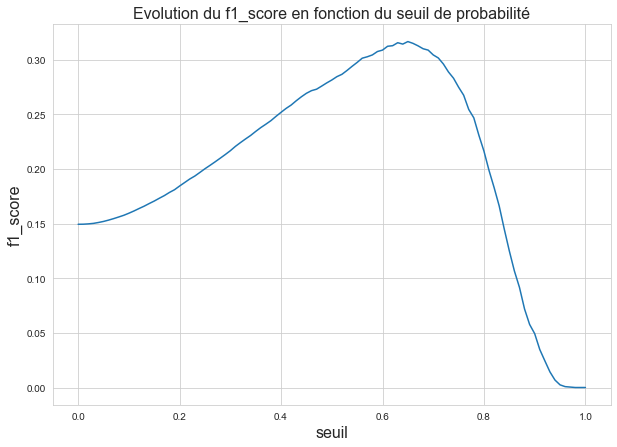

In [91]:
list_f1_score = []
y_pred_proba = best_model.predict_proba(X_val_scaled)
for i in np.arange(0, 1.01, 0.01):
    y_pred_th = (y_pred_proba[:,1] >= i).astype(bool)
    f1score = f1_score(y_val, y_pred_th)
    list_f1_score.append(f1score)
    
for i, j in enumerate(list_f1_score):
    if j == max(list_f1_score):
        best_threshold = i/100
        best_f1score = j
        print("best threshold:", best_threshold)    
        print("best f1_score: {:.2f}".format(best_f1score))

plt.figure(figsize=(10,7))
plt.plot(list(np.arange(0, 1.01, 0.01)), list_f1_score)
plt.xlabel('seuil', fontsize = 16)
plt.ylabel('f1_score', fontsize = 16)
plt.title('Evolution du f1_score en fonction du seuil de probabilité', fontsize = 16)

In [92]:
y_pred_th_best = (y_pred_proba[:,1] >= best_threshold).astype(bool)

best_recall = recall_score(y_val, y_pred_th_best)
best_precision = precision_score(y_val, y_pred_th_best)
best_f1score = f1_score(y_val, y_pred_th_best)
cm_xgb = confusion_matrix(y_val, y_pred_th_best)
print(cm_xgb,'\n')
print(classification_report(y_val, y_pred_th_best))

[[50522  6015]
 [ 2900  2065]] 

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     56537
           1       0.26      0.42      0.32      4965

    accuracy                           0.86     61502
   macro avg       0.60      0.65      0.62     61502
weighted avg       0.89      0.86      0.87     61502



In [93]:
df_scores.loc['XGBC_overSampling_th', 'recall'] = best_recall
df_scores.loc['XGBC_overSampling_th', 'precision'] = best_precision
df_scores.loc['XGBC_overSampling_th', 'f1_score'] = best_f1score
df_scores.loc['XGBC_overSampling_th', 'TP'] = cm_xgb[1][1]
df_scores.loc['XGBC_overSampling_th', 'confusion_matrix'] = cm_xgb
df_scores.loc['XGBC_overSampling_th', 'threshold'] = best_threshold
df_scores.loc['XGBC_overSampling_th', 'best_param'] = str(best_parameters)

In [94]:
df_scores

,recall,precision,f1_score,TP,confusion_matrix,threshold,best_param
XGBC,0.108761,0.226605,0.146979,540,"[[54694, 1843], [4425, 540]]",0.5,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_th,0.411078,0.166803,0.237312,2041,"[[46342, 10195], [2924, 2041]]",0.09,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_underSampling,0.697684,0.166892,0.269352,3464,"[[39245, 17292], [1501, 3464]]",0.5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_underSampling_th,0.407452,0.253541,0.312577,2023,"[[50581, 5956], [2942, 2023]]",0.69,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_overSampling,0.281414,0.181574,0.281414,3104,"[[42546, 13991], [1861, 3104]]",0.5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."
XGBC_overSampling_th,0.415911,0.255569,0.316596,2065,"[[50522, 6015], [2900, 2065]]",0.65,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."


#### class weights Gridsearch

In [95]:
#création d'une grille d'hyperparamètres

parameters = {"n_estimators" : [200, 400],
              "learning_rate" : [0.01, 0.1],
              "max_depth" : [3, 6, 10]}

param_grid = ParameterGrid(parameters)

In [96]:
#gridsearch

import time
print("Début de l'optimisation des paramètres:")
print('{} configurations à traiter'.format(len(param_grid)))
now = time.asctime()
print(now, '\n')

best_score = 0
best_recall = 0
best_precision = 0
best_model = None
best_parameters = None
best_pred = None
best_cm = None
count = 0


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
sample_weights_train = y_train.copy()
sample_weights_train = np.where(sample_weights_train == 1, ratio, 1)


for parameter in param_grid:
    
    xgb = XGBClassifier(n_estimators = parameter['n_estimators'],
                        learning_rate = parameter['learning_rate'],
                        max_depth=parameter['max_depth'])
   
    xgb.fit(X_train_scaled, y_train, sample_weight = sample_weights_train)
    
    y_pred = xgb.predict(X_val_scaled)
    
    f1score = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    if f1score > best_score:
        best_score = f1score
        best_recall = recall
        best_precision = precision
        best_model = xgb
        best_parameters = parameter
        best_pred = y_pred
        best_cm = cm
    
    print('étape {} terminée'.format(count))
    now = time.asctime()
    print('paramètres:',parameter)
    print('f1score:', f1score)
    print(cm)
    print(now,'\n')
    
    
    count += 1    

Début de l'optimisation des paramètres:
12 configurations à traiter
Wed Jan 13 20:20:31 2021 

étape 0 terminée
paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
f1score: 0.24859771146511106
[[38084 18453]
 [ 1641  3324]]
Wed Jan 13 20:29:26 2021 

étape 1 terminée
paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
f1score: 0.258374666157955
[[38678 17859]
 [ 1579  3386]]
Wed Jan 13 20:47:05 2021 

étape 2 terminée
paramètres: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
f1score: 0.25969433858484264
[[39354 17183]
 [ 1660  3305]]
Wed Jan 13 21:02:05 2021 

étape 3 terminée
paramètres: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 400}
f1score: 0.26870500687535387
[[40098 16439]
 [ 1643  3322]]
Wed Jan 13 21:33:16 2021 

étape 4 terminée
paramètres: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}
f1score: 0.275647171620326
[[43517 13020]
 [ 2090  2875]]
Wed Jan 13 21:58:59 2021 

étape 5 terminée
paramè

In [97]:
df_scores.loc['XGBC_CW', 'recall'] = best_recall
df_scores.loc['XGBC_CW', 'precision'] = best_precision
df_scores.loc['XGBC_CW', 'f1_score'] = best_score
df_scores.loc['XGBC_CW', 'TP'] = best_cm[1][1]
df_scores.loc['XGBC_CW', 'confusion_matrix'] = best_cm
df_scores.loc['XGBC_CW', 'threshold'] = 0.5
df_scores.loc['XGBC_CW', 'best_param'] = str(best_parameters)

In [98]:
df_scores

,recall,precision,f1_score,TP,confusion_matrix,threshold,best_param
XGBC,0.108761,0.226605,0.146979,540,"[[54694, 1843], [4425, 540]]",0.5,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_th,0.411078,0.166803,0.237312,2041,"[[46342, 10195], [2924, 2041]]",0.09,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_underSampling,0.697684,0.166892,0.269352,3464,"[[39245, 17292], [1501, 3464]]",0.5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_underSampling_th,0.407452,0.253541,0.312577,2023,"[[50581, 5956], [2942, 2023]]",0.69,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_overSampling,0.281414,0.181574,0.281414,3104,"[[42546, 13991], [1861, 3104]]",0.5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."
XGBC_overSampling_th,0.415911,0.255569,0.316596,2065,"[[50522, 6015], [2900, 2065]]",0.65,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."
XGBC_CW,0.439678,0.21854,0.291962,2183,"[[48731, 7806], [2782, 2183]]",0.5,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."


In [99]:
dict_models['XGBC_CW'] = best_model

In [100]:
dict_scaler['std_XGBC_CW'] = scaler

best threshold: 0.54
best f1_score: 0.29


Text(0.5, 1.0, 'Evolution du f1_score en fonction du seuil de probabilité')

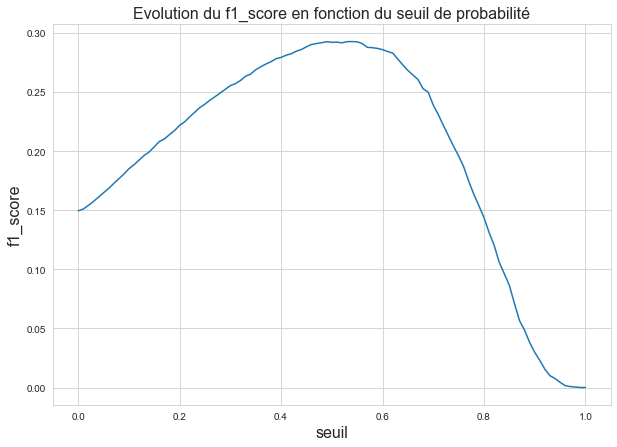

In [101]:
list_f1_score = []
y_pred_proba = best_model.predict_proba(X_val_scaled)
for i in np.arange(0, 1.01, 0.01):
    y_pred_th = (y_pred_proba[:,1] >= i).astype(bool)
    f1score = f1_score(y_val, y_pred_th)
    list_f1_score.append(f1score)
    
for i, j in enumerate(list_f1_score):
    if j == max(list_f1_score):
        best_threshold = i/100
        best_f1score = j
        print("best threshold:", best_threshold)    
        print("best f1_score: {:.2f}".format(best_f1score))

plt.figure(figsize=(10,7))
plt.plot(list(np.arange(0, 1.01, 0.01)), list_f1_score)
plt.xlabel('seuil', fontsize = 16)
plt.ylabel('f1_score', fontsize = 16)
plt.title('Evolution du f1_score en fonction du seuil de probabilité', fontsize = 16)

In [102]:
y_pred_th_best = (y_pred_proba[:,1] >= best_threshold).astype(bool)

best_recall = recall_score(y_val, y_pred_th_best)
best_precision = precision_score(y_val, y_pred_th_best)
best_f1score = f1_score(y_val, y_pred_th_best)
cm_xgb = confusion_matrix(y_val, y_pred_th_best)
print(cm_xgb,'\n')
print(classification_report(y_val, y_pred_th_best))

[[50181  6356]
 [ 3025  1940]] 

              precision    recall  f1-score   support

           0       0.94      0.89      0.91     56537
           1       0.23      0.39      0.29      4965

    accuracy                           0.85     61502
   macro avg       0.59      0.64      0.60     61502
weighted avg       0.89      0.85      0.86     61502



In [103]:
df_scores.loc['XGBC_CW_th', 'recall'] = best_recall
df_scores.loc['XGBC_CW_th', 'precision'] = best_precision
df_scores.loc['XGBC_CW_th', 'f1_score'] = best_f1score
df_scores.loc['XGBC_CW_th', 'TP'] = cm_xgb[1][1]
df_scores.loc['XGBC_CW_th', 'confusion_matrix'] = cm_xgb
df_scores.loc['XGBC_CW_th', 'threshold'] = best_threshold
df_scores.loc['XGBC_CW_th', 'best_param'] = str(best_parameters)

In [104]:
df_scores

,recall,precision,f1_score,TP,confusion_matrix,threshold,best_param
XGBC,0.108761,0.226605,0.146979,540,"[[54694, 1843], [4425, 540]]",0.5,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_th,0.411078,0.166803,0.237312,2041,"[[46342, 10195], [2924, 2041]]",0.09,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_underSampling,0.697684,0.166892,0.269352,3464,"[[39245, 17292], [1501, 3464]]",0.5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_underSampling_th,0.407452,0.253541,0.312577,2023,"[[50581, 5956], [2942, 2023]]",0.69,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_overSampling,0.281414,0.181574,0.281414,3104,"[[42546, 13991], [1861, 3104]]",0.5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."
XGBC_overSampling_th,0.415911,0.255569,0.316596,2065,"[[50522, 6015], [2900, 2065]]",0.65,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."
XGBC_CW,0.439678,0.21854,0.291962,2183,"[[48731, 7806], [2782, 2183]]",0.5,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
XGBC_CW_th,0.390735,0.233848,0.292587,1940,"[[50181, 6356], [3025, 1940]]",0.54,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."


#### scale_pos_weight

scale_pos_weight est un hyperparamètre de xgboost. Il est utilisé pour redimensionner les erreurs faites par le modèle pendant l'entraînement sur la classe minoritaire et encourage le modèle à les sur-corriger.  
D'après la documentation, une valeur raisonnable par défaut : (nb total de cas dans la classe majoritaire)/(nb total de cas dans la classe minoritaire).  
Par défaut, scale_pos_weight = 1

In [105]:
#création d'une grille d'hyperparamètres

ratio = y_train.value_counts()[0]/y_train.value_counts()[1]

parameters = {"n_estimators" : [200, 400],
              "learning_rate" : [0.01, 0.1, 1],
              "max_depth" : [3, 6, 10],
             "scale_pos_weight" : [ratio]}

param_grid = ParameterGrid(parameters)

In [106]:
#gridsearch

import time
print("Début de l'optimisation des paramètres:")
print('{} configurations à traiter'.format(len(param_grid)))
now = time.asctime()
print(now, '\n')

best_score = 0
best_recall = 0
best_precision = 0
best_model = None
best_parameters = None
best_pred = None
best_cm = None
count = 0


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

ratio = y_train.value_counts()[0]/y_train.value_counts()[1]
sample_weights_train = y_train.copy()
sample_weights_train = np.where(sample_weights_train == 1, ratio, 1)


for parameter in param_grid:
    
    xgb = XGBClassifier(n_estimators = parameter['n_estimators'],
                        learning_rate = parameter['learning_rate'],
                        max_depth=parameter['max_depth'],
                       scale_pos_weight = parameter['scale_pos_weight'])
   
    xgb.fit(X_train_scaled, y_train)
    
    y_pred = xgb.predict(X_val_scaled)
    
    f1score = f1_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    if f1score > best_score:
        best_score = f1score
        best_recall = recall
        best_precision = precision
        best_model = xgb
        best_parameters = parameter
        best_pred = y_pred
        best_cm = cm
    
    print('étape {} terminée'.format(count))
    now = time.asctime()
    print('paramètres:',parameter)
    print('f1score:', f1score)
    print(cm)
    print(now,'\n')
    
    
    count += 1  

Début de l'optimisation des paramètres:
18 configurations à traiter
Thu Jan 14 01:08:15 2021 

étape 0 terminée
paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 11.38710976837865}
f1score: 0.24859771146511106
[[38084 18453]
 [ 1641  3324]]
Thu Jan 14 01:17:09 2021 

étape 1 terminée
paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'scale_pos_weight': 11.38710976837865}
f1score: 0.258374666157955
[[38678 17859]
 [ 1579  3386]]
Thu Jan 14 01:34:39 2021 

étape 2 terminée
paramètres: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'scale_pos_weight': 11.38710976837865}
f1score: 0.25969433858484264
[[39354 17183]
 [ 1660  3305]]
Thu Jan 14 01:49:39 2021 

étape 3 terminée
paramètres: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 400, 'scale_pos_weight': 11.38710976837865}
f1score: 0.26870500687535387
[[40098 16439]
 [ 1643  3322]]
Thu Jan 14 02:19:35 2021 

étape 4 terminée
paramètres: {'learning_rat

In [107]:
df_scores.loc['XGBC_scale_pos_W', 'recall'] = best_recall
df_scores.loc['XGBC_scale_pos_W', 'precision'] = best_precision
df_scores.loc['XGBC_scale_pos_W', 'f1_score'] = best_score
df_scores.loc['XGBC_scale_pos_W', 'TP'] = best_cm[1][1]
df_scores.loc['XGBC_scale_pos_W', 'confusion_matrix'] = best_cm
df_scores.loc['XGBC_scale_pos_W', 'threshold'] = 0.5
df_scores.loc['XGBC_scale_pos_W', 'best_param'] = str(best_parameters)

In [108]:
df_scores

,recall,precision,f1_score,TP,confusion_matrix,threshold,best_param
XGBC,0.108761,0.226605,0.146979,540,"[[54694, 1843], [4425, 540]]",0.5,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_th,0.411078,0.166803,0.237312,2041,"[[46342, 10195], [2924, 2041]]",0.09,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_underSampling,0.697684,0.166892,0.269352,3464,"[[39245, 17292], [1501, 3464]]",0.5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_underSampling_th,0.407452,0.253541,0.312577,2023,"[[50581, 5956], [2942, 2023]]",0.69,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_overSampling,0.281414,0.181574,0.281414,3104,"[[42546, 13991], [1861, 3104]]",0.5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."
XGBC_overSampling_th,0.415911,0.255569,0.316596,2065,"[[50522, 6015], [2900, 2065]]",0.65,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."
XGBC_CW,0.439678,0.21854,0.291962,2183,"[[48731, 7806], [2782, 2183]]",0.5,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
XGBC_CW_th,0.390735,0.233848,0.292587,1940,"[[50181, 6356], [3025, 1940]]",0.54,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
XGBC_scale_pos_W,0.439678,0.21854,0.291962,2183,"[[48731, 7806], [2782, 2183]]",0.5,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."


In [109]:
dict_models['XGBC_scale_pos_W'] = best_model

In [110]:
dict_scaler['std_XGBC_CW'] = scaler

best threshold: 0.54
best f1_score: 0.29


Text(0.5, 1.0, 'Evolution du f1_score en fonction du seuil de probabilité')

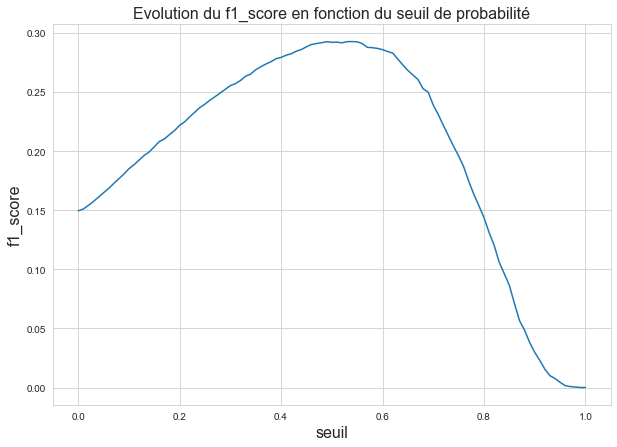

In [111]:
list_f1_score = []
y_pred_proba = best_model.predict_proba(X_val_scaled)
for i in np.arange(0, 1.01, 0.01):
    y_pred_th = (y_pred_proba[:,1] >= i).astype(bool)
    f1score = f1_score(y_val, y_pred_th)
    list_f1_score.append(f1score)
    
for i, j in enumerate(list_f1_score):
    if j == max(list_f1_score):
        best_threshold = i/100
        best_f1score = j
        print("best threshold:", best_threshold)    
        print("best f1_score: {:.2f}".format(best_f1score))

plt.figure(figsize=(10,7))
plt.plot(list(np.arange(0, 1.01, 0.01)), list_f1_score)
plt.xlabel('seuil', fontsize = 16)
plt.ylabel('f1_score', fontsize = 16)
plt.title('Evolution du f1_score en fonction du seuil de probabilité', fontsize = 16)

In [112]:
y_pred_th_best = (y_pred_proba[:,1] >= best_threshold).astype(bool)

best_recall = recall_score(y_val, y_pred_th_best)
best_precision = precision_score(y_val, y_pred_th_best)
best_f1score = f1_score(y_val, y_pred_th_best)
cm_xgb = confusion_matrix(y_val, y_pred_th_best)
print(cm_xgb,'\n')
print(classification_report(y_val, y_pred_th_best))

[[50181  6356]
 [ 3025  1940]] 

              precision    recall  f1-score   support

           0       0.94      0.89      0.91     56537
           1       0.23      0.39      0.29      4965

    accuracy                           0.85     61502
   macro avg       0.59      0.64      0.60     61502
weighted avg       0.89      0.85      0.86     61502



In [113]:
df_scores.loc['XGBC_scale_pos_W_th', 'recall'] = best_recall
df_scores.loc['XGBC_scale_pos_W_th', 'precision'] = best_precision
df_scores.loc['XGBC_scale_pos_W_th', 'f1_score'] = best_f1score
df_scores.loc['XGBC_scale_pos_W_th', 'TP'] = cm_xgb[1][1]
df_scores.loc['XGBC_scale_pos_W_th', 'confusion_matrix'] = cm_xgb
df_scores.loc['XGBC_scale_pos_W_th', 'threshold'] = best_threshold
df_scores.loc['XGBC_scale_pos_W_th', 'best_param'] = str(best_parameters)

In [114]:
df_scores

,recall,precision,f1_score,TP,confusion_matrix,threshold,best_param
XGBC,0.108761,0.226605,0.146979,540,"[[54694, 1843], [4425, 540]]",0.5,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_th,0.411078,0.166803,0.237312,2041,"[[46342, 10195], [2924, 2041]]",0.09,"{'learning_rate': 1, 'max_depth': 6, 'n_estima..."
XGBC_underSampling,0.697684,0.166892,0.269352,3464,"[[39245, 17292], [1501, 3464]]",0.5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_underSampling_th,0.407452,0.253541,0.312577,2023,"[[50581, 5956], [2942, 2023]]",0.69,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
XGBC_overSampling,0.281414,0.181574,0.281414,3104,"[[42546, 13991], [1861, 3104]]",0.5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."
XGBC_overSampling_th,0.415911,0.255569,0.316596,2065,"[[50522, 6015], [2900, 2065]]",0.65,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."
XGBC_CW,0.439678,0.21854,0.291962,2183,"[[48731, 7806], [2782, 2183]]",0.5,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
XGBC_CW_th,0.390735,0.233848,0.292587,1940,"[[50181, 6356], [3025, 1940]]",0.54,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
XGBC_scale_pos_W,0.439678,0.21854,0.291962,2183,"[[48731, 7806], [2782, 2183]]",0.5,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
XGBC_scale_pos_W_th,0.390735,0.233848,0.292587,1940,"[[50181, 6356], [3025, 1940]]",0.54,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."


## scores export

In [115]:
df_scores.to_csv('scores_models_optimisation_f1score.csv')

In [214]:
df_scores_gain.to_csv('scores_models_optimisation_f1score&gain.csv')

# Performance

Evaluation du modèle à partir du test_train

In [219]:
final_model = dict_models['XGBC_overSampling']
thresh = df_scores.iloc[5][5]

final_scaler = dict_scaler['std_XGBC_overSampling']
X_test_scaled = final_scaler.transform(X_test)

In [220]:
y_pred_test = (final_model.predict_proba(X_test_scaled)[:,1] >= thresh).astype(int)

best threshold: 0.37
best f1_score: 0.26


Text(0.5, 1.0, 'Evolution du f1_score en fonction du seuil de probabilité')

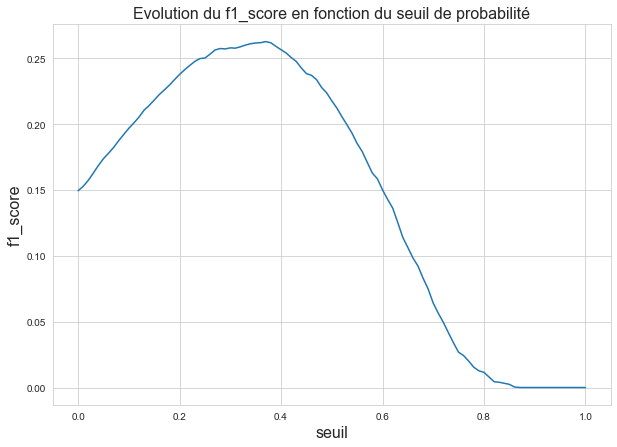

In [221]:
list_f1_score = []
y_pred_test_proba = best_model.predict_proba(X_test_scaled)

for i in np.arange(0, 1.01, 0.01):
    y_pred_th = (y_pred_test_proba[:,1] >= i).astype(bool)
    f1score = f1_score(y_test, y_pred_th)
    list_f1_score.append(f1score)
    
for i, j in enumerate(list_f1_score):
    if j == max(list_f1_score):
        best_threshold = i/100
        best_f1score = j
        print("best threshold:", best_threshold)    
        print("best f1_score: {:.2f}".format(best_f1score))

plt.figure(figsize=(10,7))
plt.plot(list(np.arange(0, 1.01, 0.01)), list_f1_score)
plt.xlabel('seuil', fontsize = 16)
plt.ylabel('f1_score', fontsize = 16)
plt.title('Evolution du f1_score en fonction du seuil de probabilité', fontsize = 16)

In [222]:
y_pred_th_best = (y_pred_test_proba[:,1] >= best_threshold).astype(bool)

best_recall = recall_score(y_test, y_pred_th_best)
best_precision = precision_score(y_test, y_pred_th_best)
best_f1score = f1_score(y_test, y_pred_th_best)
cm_xgb = confusion_matrix(y_test, y_pred_th_best)
print(cm_xgb,'\n')
print(classification_report(y_test, y_pred_th_best))

[[50093  6445]
 [ 3240  1725]] 

              precision    recall  f1-score   support

           0       0.94      0.89      0.91     56538
           1       0.21      0.35      0.26      4965

    accuracy                           0.84     61503
   macro avg       0.58      0.62      0.59     61503
weighted avg       0.88      0.84      0.86     61503



# Cost function (business problem)

Une fonction de coût métier est proposée telle que:  
  
Gain = 0.3*TN - 0.3*FP - 0.8*FN  
  
On considère que l'entreprise gagne 30% (intérêts) du montant du crédit lorsqu'un prêt es accordé et remboursé (TN), un coût d'opportunité de 30% pour un crédit refusé alors qu'il aurait été remboursé, et un coût de 80% du montant du crédit pour un crédit accordé mais partiellement remboursé( à hauteur de 80% en moyenne).

In [134]:
best_gain = 0.3*y_test.value_counts()[0]
print('Gain optimum (jeu de test): {}'.format(int(best_gain)))

Gain optimum (jeu de test): 16961


In [135]:
gain = 0.3*cm_xgb[0,0] - 0.3*cm_xgb[0,1] - 0.8*cm_xgb[1,0]
print("Gain prévisible à partir du modèle proposé (jeu de test): {}".format(int(gain)))

Gain prévisible à partir du modèle proposé (jeu de test): 10502


In [136]:
#soit une différence de :
delta = best_gain - gain
pourcent = delta/best_gain*100
print("Soit une différence de {}, c'est à dire {}%.".format(int(delta), int(pourcent)))

Soit une différence de 6458, c'est à dire 38%.


In [201]:
df_scores_gain = df_scores.copy()

list_gain = []

for i in range(len(df_scores)):
    cm = df_scores.iloc[i][4]
    gain = 0.3*cm[0,0] - 0.3*cm[0,1] - 0.8*cm[1,0]
    df_scores_gain.iloc[i][7] = gain
    list_gain.append(gain)
    
df_scores_gain['gain'] = list_gain

df_scores_gain

/Users/guillou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,recall,precision,f1_score,TP,confusion_matrix,threshold,best_param,gain
XGBC,0.108761,0.226605,0.146979,540,"[[54694, 1843], [4425, 540]]",0.5,"{'learning_rate': 1, 'max_depth': 6, 'n_estima...",12315.3
XGBC_th,0.411078,0.166803,0.237312,2041,"[[46342, 10195], [2924, 2041]]",0.09,"{'learning_rate': 1, 'max_depth': 6, 'n_estima...",8504.9
XGBC_underSampling,0.697684,0.166892,0.269352,3464,"[[39245, 17292], [1501, 3464]]",0.5,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",5385.1
XGBC_underSampling_th,0.407452,0.253541,0.312577,2023,"[[50581, 5956], [2942, 2023]]",0.69,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",11033.9
XGBC_overSampling,0.281414,0.181574,0.281414,3104,"[[42546, 13991], [1861, 3104]]",0.5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",7077.7
XGBC_overSampling_th,0.415911,0.255569,0.316596,2065,"[[50522, 6015], [2900, 2065]]",0.65,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",11032.1
XGBC_CW,0.439678,0.21854,0.291962,2183,"[[48731, 7806], [2782, 2183]]",0.5,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",10051.9
XGBC_CW_th,0.390735,0.233848,0.292587,1940,"[[50181, 6356], [3025, 1940]]",0.54,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",10727.5
XGBC_scale_pos_W,0.439678,0.21854,0.291962,2183,"[[48731, 7806], [2782, 2183]]",0.5,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",10051.9
XGBC_scale_pos_W_th,0.390735,0.233848,0.292587,1940,"[[50181, 6356], [3025, 1940]]",0.54,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",10727.5


# Pickle

Export du modèle au format pickle en vue de la production d'un dashboard interactif à destination des chargés de clientèle.

In [137]:
pkl_filename = 'ressources_dash/final_model_f1score.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(final_model, file)

In [138]:
pkl_filename_th = 'ressources_dash/threshold_final_f1score.pkl'
with open(pkl_filename_th, 'wb') as file:
    pickle.dump(thresh, file)

In [139]:
pkl_filename_std = 'ressources_dash/final_model_scaler_f1score.pkl'
with open(pkl_filename_std, 'wb') as file:
    pickle.dump(scaler, file)

## verifications

In [16]:
with open(pkl_filename, 'rb') as file:
    loaded_model = pickle.load(file)

NameError: name 'pkl_filename' is not defined

In [505]:
with open('ressources_dash/threshold_final_f1score.pkl', 'rb') as file:
    loaded_thresh = pickle.load(file)

In [142]:
with open(pkl_filename_std, 'rb') as file:
    loaded_STD = pickle.load(file)

In [143]:
X_val_scaled = loaded_STD.transform(X_val)

In [144]:
y_pred_proba = loaded_model.predict_proba(X_val_scaled)

In [145]:
(y_pred_proba[:,1]>=loaded_thresh).astype(int)

array([1, 0, 0, ..., 0, 0, 0])

In [146]:
pd.DataFrame(y_pred_proba).head(2)

,0,1
0,0.309253,0.690747
1,0.657248,0.342752


In [147]:
y_pred = loaded_model.predict(X_val_scaled)
cm_final_model = confusion_matrix(y_pred, y_val)
cm

array([[54850,  1687],
       [ 4375,   590]])

# final predict _ export data

Le modèle est finalement appliqué à l'ensemble du dataset, fournissant ainsi une probabilité et une prédiction pour l'ensemble du dataset. Ces résultats sont ensuite exportés pour usage dans le dashboard.

In [612]:
dfdata_0 = pd.read_csv('data.csv')

In [613]:
imputer = SimpleImputer(strategy = 'median')
imputer.fit_transform(dfdata_0)

array([[ 1.00002000e+05,  0.00000000e+00,  0.00000000e+00, ...,
         1.21977778e-01,  6.07492668e-02, -6.73290350e-02],
       [ 1.00003000e+05,  0.00000000e+00,  0.00000000e+00, ...,
         1.32216667e-01,  2.75983232e-02, -7.08619147e-02],
       [ 1.00004000e+05,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e-01,  5.00000000e-02, -1.18135041e-02],
       ...,
       [ 4.56253000e+05,  0.00000000e+00,  0.00000000e+00, ...,
         1.95941176e-01,  4.42387378e-02, -5.29266337e-01],
       [ 4.56254000e+05,  0.00000000e+00,  0.00000000e+00, ...,
         1.18157895e-01,  5.45923206e-02, -4.00133768e-01],
       [ 4.56255000e+05,  0.00000000e+00,  0.00000000e+00, ...,
         3.11857143e-01,  7.27666667e-02, -7.48694827e-02]])

In [614]:
dfdata_dash = dfdata_0[['SK_ID_CURR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                      'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                        'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_GOODS_PRICE', 'CREDIT_TERM',
                        'TARGET']]

In [615]:
dfdata_dash['FLAG_OWN_REALTY_NAME'] = ""

dfdata_dash['FLAG_OWN_REALTY_NAME'].loc[dfdata_0['FLAG_OWN_REALTY'] == 1] = 'Propriétaire'
dfdata_dash['FLAG_OWN_REALTY_NAME'].loc[dfdata_0['FLAG_OWN_REALTY'] == 0] = 'Non Propriétaire'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [616]:
dfdata_dash['NAME_INCOME_TYPE'] = ""

dfdata_dash['NAME_INCOME_TYPE'].loc[dfdata_0['NAME_INCOME_TYPE_Businessman'] == 1] = 'Businessman'
dfdata_dash['NAME_INCOME_TYPE'].loc[dfdata_0['NAME_INCOME_TYPE_Commercial associate'] == 1] = 'Commercial associate'
dfdata_dash['NAME_INCOME_TYPE'].loc[dfdata_0['NAME_INCOME_TYPE_Pensioner'] == 1] = 'Pensioner'
dfdata_dash['NAME_INCOME_TYPE'].loc[dfdata_0['NAME_INCOME_TYPE_State servant'] == 1] = 'State servant'
dfdata_dash['NAME_INCOME_TYPE'].loc[dfdata_0['NAME_INCOME_TYPE_Student'] == 1] = 'Student'
dfdata_dash['NAME_INCOME_TYPE'].loc[dfdata_0['NAME_INCOME_TYPE_Unemployed'] == 1] = 'Unemployed'
dfdata_dash['NAME_INCOME_TYPE'].loc[dfdata_0['NAME_INCOME_TYPE_Working'] == 1] = 'Working'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [617]:
dfdata_dash['NAME_FAMILY_STATUS'] = ""

dfdata_dash['NAME_FAMILY_STATUS'].loc[dfdata_0['NAME_FAMILY_STATUS_Civil marriage'] == 1] = 'Civil marriage'
dfdata_dash['NAME_FAMILY_STATUS'].loc[dfdata_0['NAME_FAMILY_STATUS_Married'] == 1] = 'Married'
dfdata_dash['NAME_FAMILY_STATUS'].loc[dfdata_0['NAME_FAMILY_STATUS_Separated'] == 1] = 'Separated'
dfdata_dash['NAME_FAMILY_STATUS'].loc[dfdata_0['NAME_FAMILY_STATUS_Single / not married'] == 1] = 'Single / not married'
dfdata_dash['NAME_FAMILY_STATUS'].loc[dfdata_0['NAME_FAMILY_STATUS_Widow'] == 1] = 'Widow'


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [618]:
X_scaled = loaded_STD.transform(X)

In [619]:
dfdata_dash['proba'] = loaded_model.predict_proba(X_scaled)[:,1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [620]:
dfdata_dash['predict'] = (dfdata_dash['proba']>=loaded_thresh).astype(int)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [621]:
dfdata_dash['DAYS_BIRTH_YEAR'] = dfdata_dash['DAYS_BIRTH'].apply(lambda x: int(x/365))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [622]:
dfdata_dash['DAYS_EMPLOYED'].loc[dfdata_dash['DAYS_EMPLOYED'].isnull() == True] = 0


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [623]:
dfdata_dash['DAYS_EMPLOYED_YEAR'] = dfdata_dash['DAYS_EMPLOYED'].apply(lambda x: abs(int(x/365)))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [624]:
#ATTENTION dfdata_clus généré à la fin dans la partie clustering
dfdata_dash = pd.concat([dfdata_dash, df_clus], axis = 1)

In [724]:
#ATTENTION dfdata_categ généré à la fin dans la partie clustering
df_toConcat = dfdata_categ[['DAYS_BIRTHcategories', 'DAYS_EMPLOYEDcategories', 'AMT_INCOME_TOTALcategories', 'code']]
dfdata_dash = pd.concat([dfdata_dash, df_toConcat], axis = 1)

In [625]:
#création de la colonne 'durée du crédit'
dfdata_dash['CREDIT_DURATION'] = round(dfdata_dash['AMT_CREDIT']/dfdata_dash['AMT_ANNUITY'], 1)

In [626]:
#création de la colonne 'taux d'endettement'
dfdata_dash['DEBT_RATIO'] = round(dfdata_dash['AMT_ANNUITY']*100/dfdata_dash['AMT_INCOME_TOTAL'], 1)

In [725]:
dfdata_dash.head(30)

,SK_ID_CURR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,...,predict,DAYS_BIRTH_YEAR,DAYS_EMPLOYED_YEAR,similaire,CREDIT_DURATION,DEBT_RATIO,DAYS_BIRTHcategories,DAYS_EMPLOYEDcategories,AMT_INCOME_TOTALcategories,code
0,100002,1,0,202500.000,406597.5,24700.5,9461,-637.0,0.083037,0.262949,...,1,25,1,9,16.5,12.2,0,1,3,031
1,100003,0,0,270000.000,1293502.5,35698.5,16765,-1188.0,0.311267,0.622246,...,0,45,3,4,36.2,13.2,2,0,3,230
2,100004,1,0,67500.000,135000.0,6750.0,19046,-225.0,NaN,0.555912,...,0,52,0,21,20.0,10.0,2,1,1,211
3,100006,1,0,135000.000,312682.5,29686.5,19005,-3039.0,NaN,0.650442,...,0,52,8,4,10.5,22.0,2,0,3,230
4,100007,1,0,121500.000,513000.0,21865.5,19932,-3038.0,NaN,0.322738,...,0,54,8,4,23.5,18.0,2,0,3,230
5,100008,1,0,99000.000,490495.5,27517.5,16941,-1588.0,NaN,0.354225,...,0,46,4,0,17.8,27.8,2,0,2,220
6,100009,1,1,171000.000,1560726.0,41301.0,13778,-3130.0,0.774761,0.724000,...,0,37,8,1,37.8,24.2,1,0,3,130
7,100010,1,0,360000.000,1530000.0,42075.0,18850,-449.0,NaN,0.714279,...,0,51,1,10,36.4,11.7,2,1,3,231
8,100011,1,0,112500.000,1019610.0,33826.5,20099,0.0,0.587334,0.205747,...,0,55,0,4,30.1,30.1,2,0,3,230
9,100012,1,0,135000.000,405000.0,20250.0,14469,-2019.0,NaN,0.746644,...,0,39,5,1,20.0,15.0,1,0,3,130


In [726]:
dfdata_dash.to_csv('ressources_dash/pred&infos.csv')

# Scores visualization

Text(0, 0.5, 'gain')

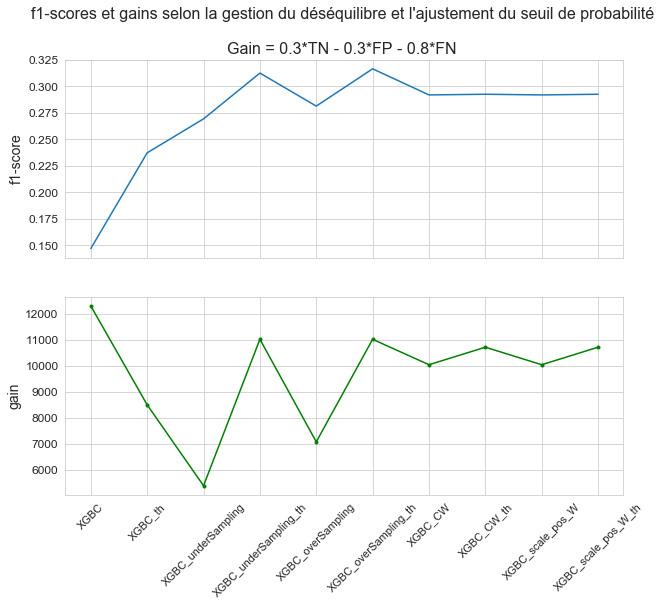

In [210]:
fig = plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(df_scores.index, df_scores.f1_score, label = "f1-scores")
#plt.plot(df_scores.index, df_scores.recall, label = 'recall')
#plt.plot(df_scores.index, df_scores.precision, label = 'precision')
#plt.legend()
plt.xticks(color = 'white')
plt.yticks(fontsize = 12)
plt.ylabel('f1-score', fontsize = 14)
plt.title("f1-scores et gains selon la gestion du déséquilibre et l'ajustement du seuil de probabilité \n \nGain = 0.3*TN - 0.3*FP - 0.8*FN ", 
          fontsize = 16)


plt.subplot(212)
plt.plot(df_scores_gain.index, df_scores_gain.gain, '.g-', label ='gain')
plt.xticks(rotation = 45, fontsize = 11)
plt.yticks(fontsize = 12)
plt.ylabel('gain', fontsize = 14)

In [211]:
fig.savefig("plot_scores_f1&gain.png")

# Interpretability with SHAP

SHAP (SHapley Additive exPlanations
TreeExplainer permet d'accéder à une approximation des valeurs de Shapley dans le cas d'arbres de décision ou d'ensemble d'arbres. TE permet de calculer l'importance globale des variables ainsi que les effets des variables pour chaque exemple du dataset.

In [216]:
#pip install shap

     |████████████████████████████████| 326 kB 4.0 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-macosx_10_7_x86_64.whl size=378923 sha256=5fcc2eb6354313029e808ca0a20ef8f9437746084d61e5432236bd98c6e2f579
  Stored in directory: /Users/guillou/Library/Caches/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built shap
Note: you may need to restart the kernel to use updated packages.


In [23]:
import shap

In [24]:
#load JS visualization code to notebook
shap.initjs()

## Approche globale

Diagramme de l'importance des variables - interprétabilité globale

### TreeExplainer proba

In [17]:
with open('ressources_dash/final_model_f1score.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [18]:
with open('ressources_dash/final_model_scaler_f1score.pkl', 'rb') as file:
    loaded_STD = pickle.load(file)

In [19]:
#mise à l'échelle
X_train_scaled = loaded_STD.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X.columns)

In [20]:
X_val = imputer.transform(X_val)

In [21]:
#X_val_scaled = final_scaler.transform(X_val)
X_val_scaled = loaded_STD.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = X.columns)

In [25]:
explainer_prob = shap.TreeExplainer(model= loaded_model,
                                    data= X_train_scaled,
                                    model_output= 'predict_proba',
                                    feature_perturbation='interventional')

In [29]:
shap_values_prob = explainer_prob.shap_values(X_train_scaled)

100%|===================| 184503/184506 [29:33<00:00]        

In [163]:
with open('ressources_dash/explainer_proba.pkl', 'wb') as file:
    pickle.dump(explainer_prob, file)

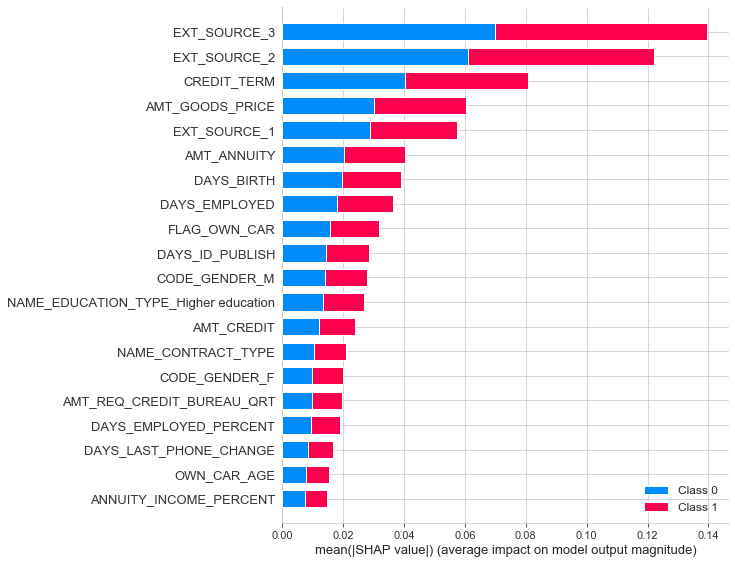

In [30]:
shap.summary_plot(shap_values_prob, X_train_scaled)

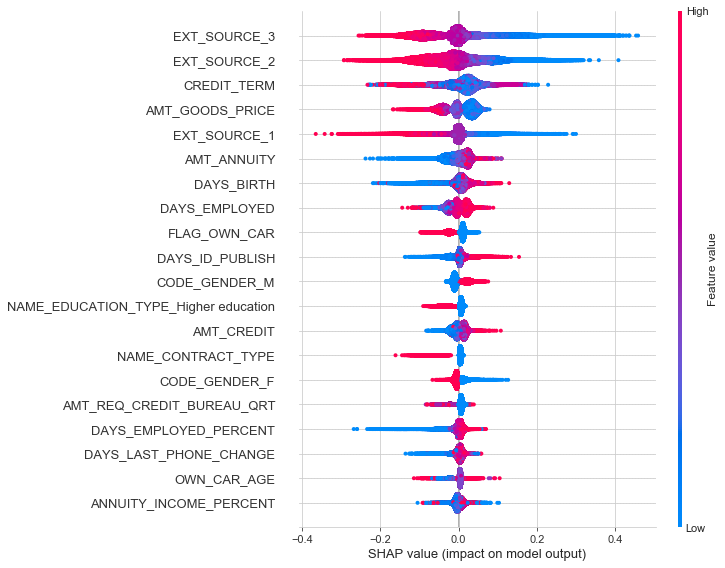

In [162]:
shap.summary_plot(shap_values_prob[1], X_train_scaled)

Ce graphique est composé de tous les points des données du train. Il montre les informations suivantes:  
Importance de la fonctionnalité: les variables sont classées par ordre décroissant.  
Impact: l'emplacement horizontal indique si l'effet de cette valeur est associé à une prédiction supérieure ou inférieure .  
Valeur d'origine: la couleur indique si cette variable est élevée (en rouge) ou basse (en bleu) pour cette observation.  
Un niveau élevé de EXT_SOURCE_3 (couleur rouge) a un impact négatif.  
Les valeurs élevées de DAYS_EMPLOYED_PERCENT ont un impact positif (à droite sur l'axe des x) par rapport à la valeur cible.

In [31]:
explainer_prob.expected_value

[0.6225023366455169, 0.3774976633544831]

In [184]:
val_abs = np.abs(shap_values_prob).mean(0)
feature_importance = pd.DataFrame(list(zip(X_val_scaled.columns, sum(val_abs))), columns=['feature', 'feature_importance'])
feature_importance.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
feature_importance.head(15)

,feature,feature_importance
33,EXT_SOURCE_3,12881.554510
32,EXT_SOURCE_2,11251.417880
242,CREDIT_TERM,7441.993166
8,AMT_GOODS_PRICE,5581.685924
31,EXT_SOURCE_1,5295.511640
7,AMT_ANNUITY,3733.418609
10,DAYS_BIRTH,3602.412104
11,DAYS_EMPLOYED,3347.548246
2,FLAG_OWN_CAR,2925.107128
13,DAYS_ID_PUBLISH,2637.537954


In [185]:
with open('ressources_dash/feature_importance.pkl', 'wb') as file:
    pickle.dump(feature_importance, file)

## Approche locale

Diagramme des valeurs SHAP individuelles - interprétabilité locale

### approche locale treeExplainer predict proba

In [26]:
#explainerModel_0 = shap.TreeExplainer(final_model)
shap_values_Model_Prob = explainer_prob.shap_values(X_val_scaled)

100%|===================| 61491/61502 [09:25<00:00]        

In [131]:
len(shap_values_Model_Prob[1])

61502

In [27]:
def forcePlotProb(j):
    p = shap.force_plot(explainer_prob.expected_value[1], shap_values_Model_Prob[1][j], X_val_scaled.iloc[j])
    return(p)

In [29]:
forcePlotProb(1)

In [89]:
dfdata[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].loc[dfdata['SK_ID_CURR'] == X_val[1][0]]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
132241,0.348161,0.260721,0.427657


In [81]:
forcePlotProb(27)

In [90]:
dfdata[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].loc[dfdata['SK_ID_CURR'] == X_val[27][0]]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
192547,0.665102,0.776166,0.676993


In [136]:
forcePlotProb(9)

In [137]:
forcePlotProb(2)

In [100]:
dfshap = pd.DataFrame(shap_values_Model_Prob[1], columns = X.columns)

In [101]:
dfval = pd.DataFrame(X_val, columns = X.columns)

(-0.1, 0.25)

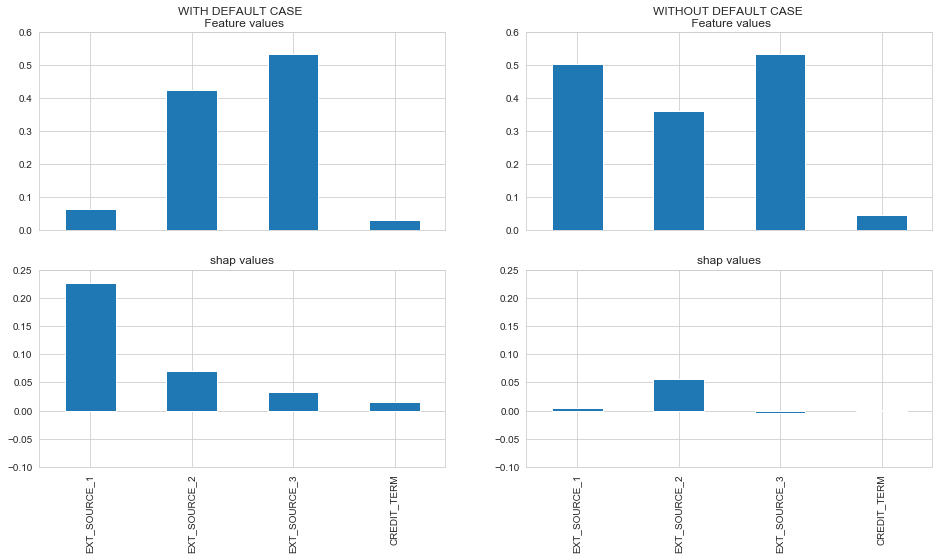

In [161]:
fig = plt.figure(figsize = (16,8))

plt.subplot(221)
dfval[['EXT_SOURCE_1', 
       'EXT_SOURCE_2', 
       'EXT_SOURCE_3',
       'CREDIT_TERM']].iloc[9].plot(kind='bar')
plt.title('WITH DEFAULT CASE \n Feature values')
plt.xticks(color = 'white')
plt.ylim(0,0.6)

plt.subplot(223)
dfshap[['EXT_SOURCE_1', 
       'EXT_SOURCE_2', 
       'EXT_SOURCE_3',
       'CREDIT_TERM']].iloc[9].plot(kind = 'bar')
plt.title('shap values')
plt.ylim(-0.1,0.25)

plt.subplot(222)
dfval[['EXT_SOURCE_1', 
       'EXT_SOURCE_2', 
       'EXT_SOURCE_3',
       'CREDIT_TERM']].iloc[0].plot(kind='bar')
plt.title('WITHOUT DEFAULT CASE \n Feature values')
plt.xticks(color = 'white')
plt.ylim(0,0.6)

plt.subplot(224)
dfshap[['EXT_SOURCE_1', 
       'EXT_SOURCE_2', 
       'EXT_SOURCE_3',
       'CREDIT_TERM']].iloc[0].plot(kind = 'bar')
plt.title('shap values')
plt.ylim(-0.1,0.25)

In [123]:
#probabilités sur les données de validation

X_output = X_val_scaled.copy()
df_X_output = pd.DataFrame(X_output)
df_X_output.loc[:,'proba'] = np.round(loaded_model.predict_proba(X_output.values)[:,1],2)
df_X_output.loc[:,'prediction'] = loaded_model.predict(X_val_scaled.values)

In [157]:
df_X_output.iloc[9][['proba','prediction']]

proba         0.78
prediction    1.00
Name: 9, dtype: float64

In [160]:
df_X_output.iloc[2][['proba','prediction']]

proba         0.17
prediction    0.00
Name: 2, dtype: float64

In [154]:
dfval[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_GOODS_PRICE', 'CREDIT_TERM']].iloc[9]

EXT_SOURCE_1            0.064457
EXT_SOURCE_2            0.424768
EXT_SOURCE_3            0.535276
AMT_GOODS_PRICE    900000.000000
CREDIT_TERM             0.029385
Name: 9, dtype: float64

## features_importances

In [251]:
df1 = pd.DataFrame(X.columns, columns=['Feature'])
df2 = pd.DataFrame(final_model.feature_importances_, columns = ['feature_importance'])

In [254]:
df_feat_imp = pd.concat((df1, df2), axis = 1)

In [258]:
df_feat_imp_head = df_feat_imp.sort_values(by = 'feature_importance', ascending = False).head(15)

Text(0.5, 1.0, 'The first 15 Feature importances')

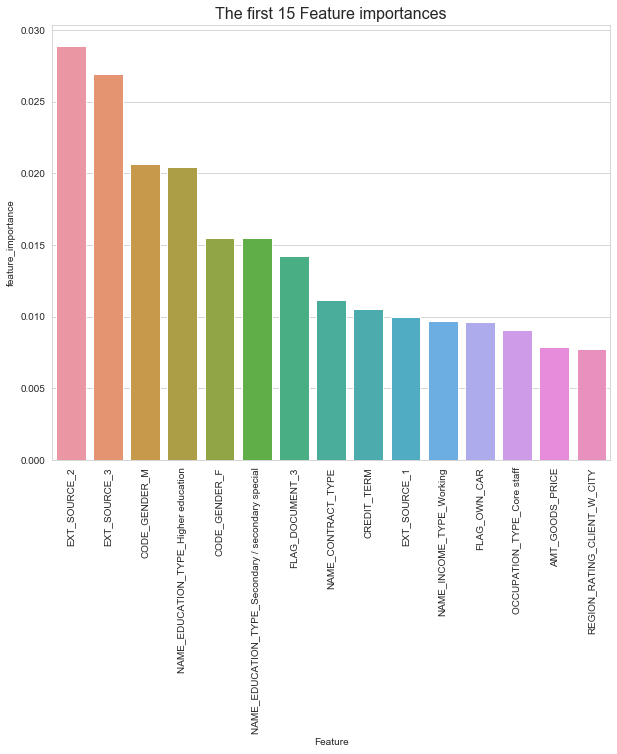

In [286]:
fig = plt.figure(figsize = (10,8))
sns.barplot(x = 'Feature', 
            y = 'feature_importance', 
            data = df_feat_imp_head)
plt.xticks(rotation = 90)
plt.title('The first 15 Feature importances', fontsize = 16)

# Clustering

In [289]:
def silh(X, max):
  """clustering K-Means: nombre max de clusters (max) à définir pour le tracé de la courbe silhouette"""
  silhouettes = []
  for num_clusters in range(2, max):
    kmeans = KMeans(n_clusters=num_clusters, init = 'k-means++', n_init = 1)
    kmeans.fit(X)
    silh = silhouette_score(X, kmeans.labels_)
    silhouettes.append(silh)
  plt.plot(range(2, max), silhouettes)
  plt.scatter(range(2, max), silhouettes)

In [256]:
def process_categ(df,col,cut_points,label_names):
    #df[col] = df[col].fillna(-0.5)
    df[col+"categories"] = pd.cut(df[col],cut_points,labels=label_names)
    return df 

Des catégories sont créées afin de faciliter le clustering en vue de proposer une comparaison de caractéristiques d'un client à celles de clients similaires.

In [190]:
dfdata[['DAYS_BIRTH','DAYS_EMPLOYED','AMT_INCOME_TOTAL']].agg(['min', 'max'])

,DAYS_BIRTH,DAYS_EMPLOYED,AMT_INCOME_TOTAL
min,7489,-17912.0,25650.0
max,25229,0.0,117000000.0


'DAYS_BIRTH': Client's age in days at the time of application  
'DAYS_EMPLOYED': How many days before the application the person started current employment  
'AMT_INCOME_TOTAL': Income of the client

In [340]:
dfdata_categ = dfdata.copy()

In [341]:
imputer = SimpleImputer(strategy = 'median')
dfdata_categ = imputer.fit_transform(dfdata_categ)

In [342]:
dfdata_categ = pd.DataFrame(dfdata_categ, columns = [dfdata.columns])

In [343]:
dfdata_categ.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002.0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,1.0,0.0,1.0,0.0,1.0,0.0,2.007889,0.121978,0.060749,-0.067329
1,100003.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,0.0,1.0,0.0,0.0,0.0,4.790750,0.132217,0.027598,-0.070862
2,100004.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.100000,0.050000,-0.011814
3,100006.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,2.316167,0.219900,0.094941,-0.159905
4,100007.0,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,4.222222,0.179963,0.042623,-0.152418


In [344]:
dfdata_categ.columns = [x[0] for x in dfdata_categ.columns]

## categorisation

### Age

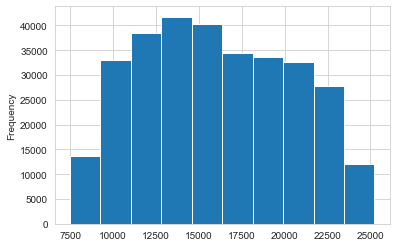

In [345]:
dfdata['DAYS_BIRTH'].plot.hist()

In [346]:
cut_points = [0,10950,16425,21900,100000]
label_names = [0,1,2,3]
#label_names = ["<30","30-45","45-60",">60"]

dfdata_categ = process_categ(dfdata_categ, 'DAYS_BIRTH', cut_points, label_names)

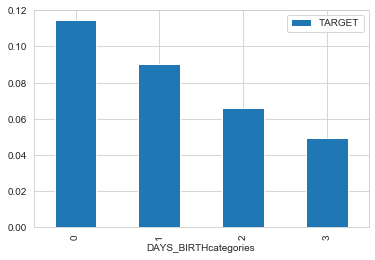

In [347]:
age_cat_pivot = dfdata_categ.pivot_table(index="DAYS_BIRTHcategories",values="TARGET")
age_cat_pivot.plot.bar()
plt.show()

In [348]:
dfdata_categ['DAYS_BIRTHcategories'].value_counts().sort_index()

0     45021
1    123714
2    103197
3     35579
Name: DAYS_BIRTHcategories, dtype: int64

### Emploi

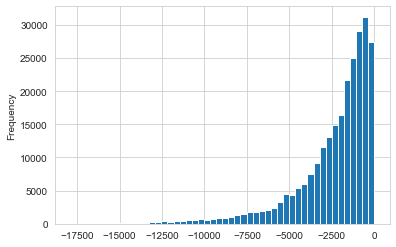

In [349]:
dfdata['DAYS_EMPLOYED'].plot.hist(bins = 50)

In [364]:
cut_points = [-20000,-730,0]
label_names = [0,1]
#label_names = [">2","<2"]

dfdata_categ = process_categ(dfdata_categ, 'DAYS_EMPLOYED', cut_points, label_names) 

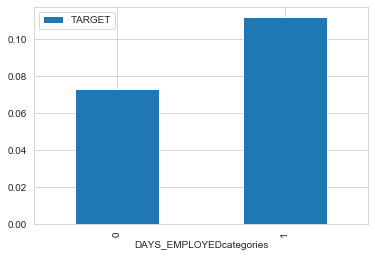

In [365]:
emplo_cat_pivot = dfdata_categ.pivot_table(index="DAYS_EMPLOYEDcategories",values="TARGET")
emplo_cat_pivot.plot.bar()
plt.show()

In [367]:
dfdata_categ['DAYS_EMPLOYEDcategories'].value_counts().sort_index()

0    247766
1     59745
Name: DAYS_EMPLOYEDcategories, dtype: int64

### revenus

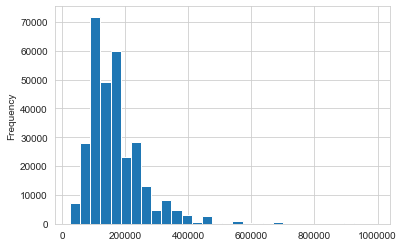

In [353]:
dfdata['AMT_INCOME_TOTAL'][dfdata['AMT_INCOME_TOTAL'] < 1e6].plot.hist(bins = 30)

In [379]:
cut_points = [0, 5e4, 7.5e4, 1e5, 1e10]
label_names = [0,1, 2, 3]

#label_names = ["<50000","50000-75000", "75000-100000", ">100000"]

dfdata_categ = process_categ(dfdata_categ, 'AMT_INCOME_TOTAL', cut_points, label_names) 

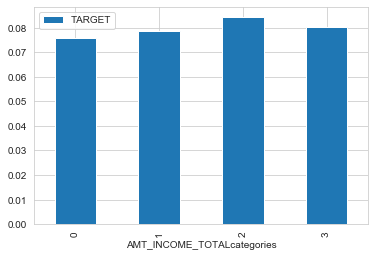

In [380]:
emplo_cat_pivot = dfdata_categ.pivot_table(index="AMT_INCOME_TOTALcategories",values="TARGET")
emplo_cat_pivot.plot.bar()
plt.show()

In [381]:
dfdata_categ['AMT_INCOME_TOTALcategories'].value_counts().sort_index()

0      4517
1     19375
2     39806
3    243813
Name: AMT_INCOME_TOTALcategories, dtype: int64

In [382]:
dfdata_categ_sel = dfdata_categ[["AMT_INCOME_TOTALcategories", "DAYS_EMPLOYEDcategories", "DAYS_BIRTHcategories"]]

In [383]:
dfdata_categ_sel.head()

,AMT_INCOME_TOTALcategories,DAYS_EMPLOYEDcategories,DAYS_BIRTHcategories
0,3,1,0
1,3,0,2
2,1,1,2
3,3,0,2
4,3,0,2


In [661]:
#concaténation des catégories
dfdata_categ['code'] = dfdata_categ['DAYS_BIRTHcategories'].astype(str) + dfdata_categ['AMT_INCOME_TOTALcategories'].astype(str) + dfdata_categ['DAYS_EMPLOYEDcategories'].astype(str)
dfdata_categ.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,DAYS_BIRTHcategories,DAYS_EMPLOYEDcategories,AMT_INCOME_TOTALcategories,code
0,100002.0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,1.0,0.0,2.007889,0.121978,0.060749,-0.067329,0,1,3,031
1,100003.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,0.0,4.790750,0.132217,0.027598,-0.070862,2,0,3,230
2,100004.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,2.000000,0.100000,0.050000,-0.011814,2,1,1,211
3,100006.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,2.316167,0.219900,0.094941,-0.159905,2,0,3,230
4,100007.0,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,4.222222,0.179963,0.042623,-0.152418,2,0,3,230


## silhouette observation on sample

In [384]:
dfdata_categ_sel_sample = dfdata_categ_sel.iloc[0:10000,:]

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This b

Text(0.5, 1.0, 'coefficient de silhouette')

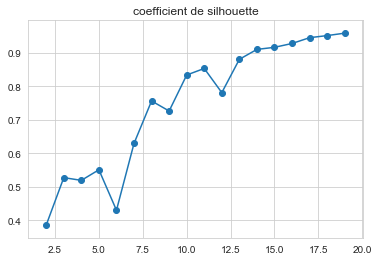

In [385]:
silh(dfdata_categ_sel_sample, 20)
plt.title('coefficient de silhouette')

## clustering KMeans

### n_clusters = 10

In [296]:
kmeanMod14 = KMeans(n_clusters = 14, init = 'k-means++', n_init = 1)
kmeanMod14.fit(dfdata_categ_sel)
print("silhouette: ", silhouette_score(dfdata_categ_sel, kmeanMod14.labels_))

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


silhouette:  0.9927911800027365


In [391]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=5000)
X_tsne = tsne.fit_transform(dfdata_categ_sel)

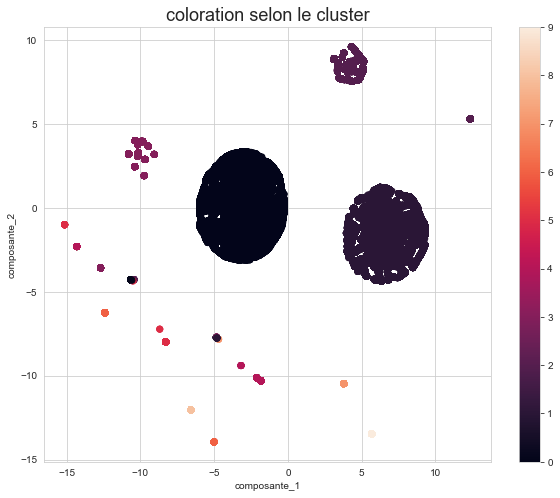

In [298]:
fig = plt.figure(figsize=(10,8))

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmeanMod.labels_)
plt.xlabel('composante_1')
plt.ylabel('composante_2')
plt.title('coloration selon le cluster', fontsize = 18)
plt.colorbar()

### n_clusters = 32

In [386]:
kmeanMod32 = KMeans(n_clusters = 32, init = 'k-means++', n_init = 1)
kmeanMod32.fit(dfdata_categ_sel)
print("silhouette: ", silhouette_score(dfdata_categ_sel, kmeanMod32.labels_))

Number of distinct clusters (31) found smaller than n_clusters (32). Possibly due to duplicate points in X.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


silhouette:  1.0


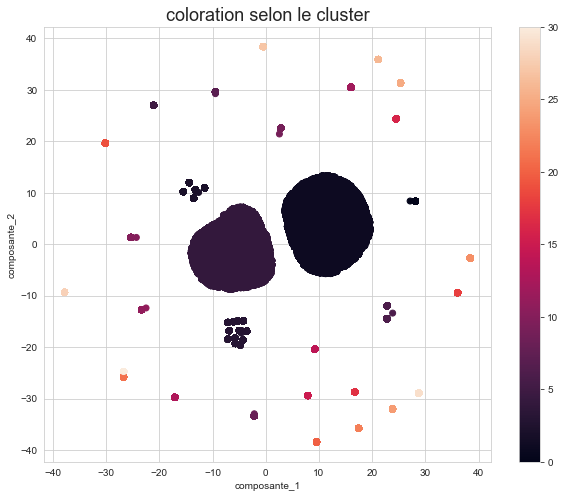

In [392]:
fig = plt.figure(figsize=(10,8))

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmeanMod32.labels_)
plt.xlabel('composante_1')
plt.ylabel('composante_2')
plt.title('coloration selon le cluster', fontsize = 18)
plt.colorbar()

In [388]:
dfdata_categ_sel_tar = pd.concat([dfdata_categ_sel, dfdata.TARGET], axis = 1)

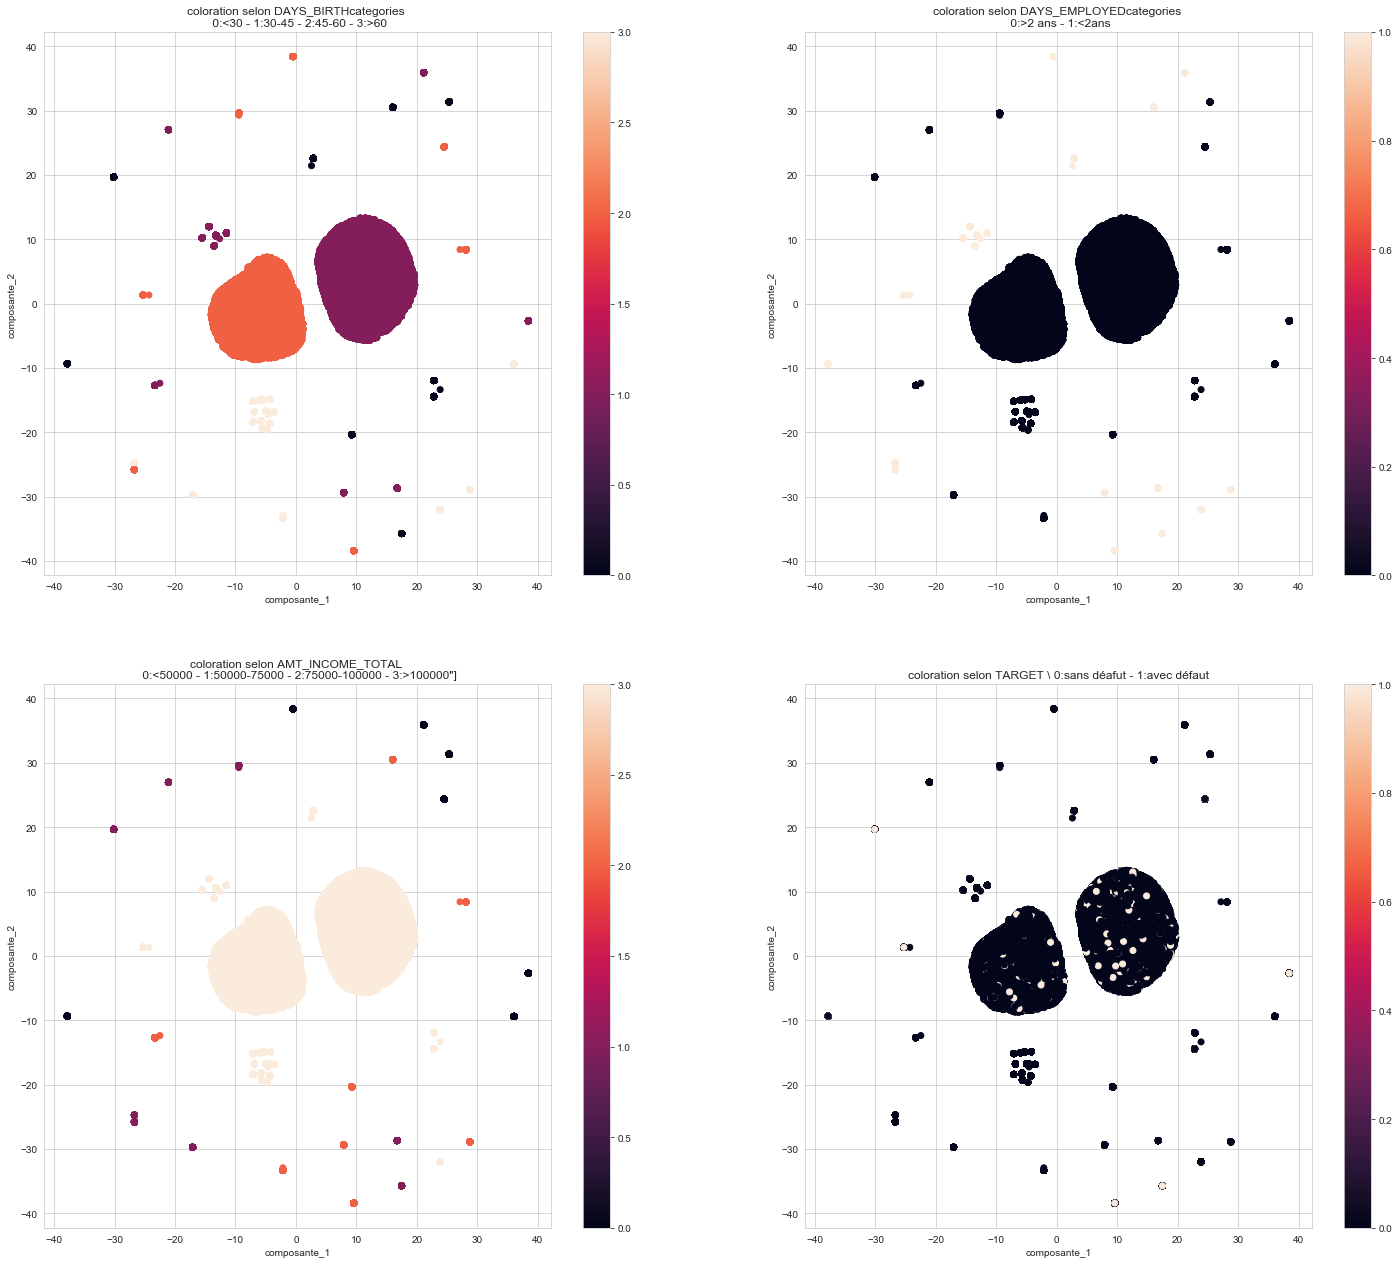

In [393]:
fig = plt.figure(figsize=(25,22))

ax = fig.add_subplot(221)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=dfdata_categ_sel.get('DAYS_BIRTHcategories'))
plt.xlabel('composante_1')
plt.ylabel('composante_2')
plt.title('coloration selon DAYS_BIRTHcategories \n 0:<30 - 1:30-45 - 2:45-60 - 3:>60')
plt.colorbar()

ax = fig.add_subplot(222)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=dfdata_categ_sel.get('DAYS_EMPLOYEDcategories'))
plt.xlabel('composante_1')
plt.ylabel('composante_2')
plt.title('coloration selon DAYS_EMPLOYEDcategories \n 0:>2 ans - 1:<2ans')
plt.colorbar()

ax = fig.add_subplot(223)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=dfdata_categ_sel.get('AMT_INCOME_TOTALcategories'))
plt.xlabel('composante_1')
plt.ylabel('composante_2')
plt.title('coloration selon AMT_INCOME_TOTAL \n 0:<50000 - 1:50000-75000 - 2:75000-100000 - 3:>100000"]')
plt.colorbar()

ax = fig.add_subplot(224)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=dfdata_categ_sel_tar.get('TARGET'))
plt.xlabel('composante_1')
plt.ylabel('composante_2')
plt.title('coloration selon TARGET \ 0:sans déafut - 1:avec défaut')
plt.colorbar()

# Reference values

## label value

In [398]:
df_clus = pd.DataFrame(kmeanMod32.labels_, columns = ['similaire'])

In [400]:
dfdata_lab = pd.concat([dfdata, df_clus], axis=1)

In [433]:
list_index = ['mean_total', 'non_default' , 'default']

In [434]:
reference = pd.DataFrame(columns = dfdata_lab.columns,
                        index = list_index)

In [436]:
#calcul des moyennes pour chaque features pour l'ensemble, des clients, ceux en défaut, et les autres
for col in reference.columns:
    reference.loc['mean_total', col] = dfdata_lab[col].mean()
    reference.loc['non_default', col] = dfdata_lab[dfdata_lab['TARGET'] == 0][col].mean()
    reference.loc['default', col] = dfdata_lab[dfdata_lab['TARGET'] == 1][col].mean()

In [493]:
reference.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,similaire
mean_total,278181,0.0952129,0.340108,0.693673,0.417052,168798,599026,27108.6,538396,0.0208681,...,0.0174368,0.518446,0.00757046,0.0807288,0.180072,3.95757,0.18093,0.053695,-0.156861,4.86809
non_default,278245,0.0979001,0.343176,0.694513,0.412946,169078,602648,27163.6,542737,0.0210207,...,0.0171285,0.524695,0.00744642,0,0.185308,3.96373,0.18053,0.0536104,-0.159656,4.83136
default,277449,0.0646123,0.305176,0.684109,0.463807,165612,557779,26481.7,488972,0.0191306,...,0.0209466,0.447291,0.00898288,1,0.120443,3.88744,0.185482,0.0546587,-0.127388,5.28636


In [429]:
reference2 = pd.DataFrame(columns = dfdata_lab.columns,
                        index = list(set(kmeanMod32.labels_)))

In [431]:
#calcul des moyennes pour chaque feature et chaque cluster (simlaire)
for index in reference2.index:
    for col in reference2.columns:
        reference2.loc[index, col] = dfdata_lab[dfdata_lab['similaire'] == index][col].mean()

In [492]:
reference2.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,similaire
0,278753,0.0978764,0.195491,0.743424,0.124006,88292.8,463049,20286.5,412918,0.018927,...,0.0168662,0.432491,0.00707856,0.060561,0.367736,5.25288,0.230235,0.0524898,-0.204691,0
1,278215,0.0888894,0.440281,0.662355,0.737822,201850,667569,30244.8,601660,0.0210494,...,0.0172764,0.541956,0.00765901,0.0804446,0.0105654,3.62284,0.164462,0.0532966,-0.19917,1
2,278846,0.0919389,0.416096,0.659203,0.716105,193334,638122,29277.6,570810,0.021776,...,0.0184844,0.544477,0.00763962,0.114067,0,3.55548,0.164331,0.0539381,-0.0292455,2
3,278616,0.0593756,0.20966,0.777931,0.0153887,173145,612895,27199.1,552480,0.0222406,...,0.0145882,0.579657,0.00591532,0.0489682,0.798479,3.7083,0.1656,0.0528132,-0.216663,3
4,278381,0.0788868,0.336004,0.749133,0.147872,194732,717513,30529.3,645601,0.0216768,...,0.0165644,0.543954,0.00734458,0.0617116,0.23389,3.99693,0.170193,0.0491688,-0.203418,4


In [442]:
reference3 = pd.concat([reference, reference2])
#reference3 = reference3.T

In [494]:
reference3.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,similaire
mean_total,278181,0.0952129,0.340108,0.693673,0.417052,168798,599026,27108.6,538396,0.0208681,...,0.0174368,0.518446,0.00757046,0.0807288,0.180072,3.95757,0.18093,0.053695,-0.156861,4.86809
non_default,278245,0.0979001,0.343176,0.694513,0.412946,169078,602648,27163.6,542737,0.0210207,...,0.0171285,0.524695,0.00744642,0,0.185308,3.96373,0.18053,0.0536104,-0.159656,4.83136
default,277449,0.0646123,0.305176,0.684109,0.463807,165612,557779,26481.7,488972,0.0191306,...,0.0209466,0.447291,0.00898288,1,0.120443,3.88744,0.185482,0.0546587,-0.127388,5.28636
0,278753,0.0978764,0.195491,0.743424,0.124006,88292.8,463049,20286.5,412918,0.018927,...,0.0168662,0.432491,0.00707856,0.060561,0.367736,5.25288,0.230235,0.0524898,-0.204691,0
1,278215,0.0888894,0.440281,0.662355,0.737822,201850,667569,30244.8,601660,0.0210494,...,0.0172764,0.541956,0.00765901,0.0804446,0.0105654,3.62284,0.164462,0.0532966,-0.19917,1


In [ ]:
reference3['DAYS_BIRTH_YEAR'] = reference3['DAYS_BIRTH'].apply(lambda x: int(x/365))
reference3['DAYS_EMPLOYED_YEAR'] = reference3['DAYS_EMPLOYED'].apply(lambda x: abs(int(x/365)))
reference3.to_csv('ressources_dash/valeurs_references.csv')

## code value for interpretation

Afin de permettre une lecture et une interprétation directe, le code créé par concaténation des catégories créées pour le clustering sont affichées plutôt que le label du cluster.

In [678]:
dfdata_categ = pd.concat([dfdata_categ, df_clus], axis=1)

In [679]:
dfdata_categ.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,DAYS_BIRTHcategories,DAYS_EMPLOYEDcategories,AMT_INCOME_TOTALcategories,code,similaire
0,100002.0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,2.007889,0.121978,0.060749,-0.067329,0,1,3,031,9
1,100003.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,4.790750,0.132217,0.027598,-0.070862,2,0,3,230,4
2,100004.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,2.000000,0.100000,0.050000,-0.011814,2,1,1,211,21
3,100006.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,2.316167,0.219900,0.094941,-0.159905,2,0,3,230,4
4,100007.0,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,4.222222,0.179963,0.042623,-0.152418,2,0,3,230,4


In [680]:
reference22 = pd.DataFrame(columns = dfdata_categ.columns,
                        index = list(set(df_code['code'])))

In [692]:
list_temp = list(dfdata_categ.columns)

In [693]:
for i in ['DAYS_BIRTHcategories', 'DAYS_EMPLOYEDcategories', 'AMT_INCOME_TOTALcategories', 'code', 'similaire']:
    list_temp.remove(i)

In [695]:
#calcul des moyennes pour chaque feature et chaque cluster (simlaire)
for index in reference22.index:
    for col in list_temp:
        reference22.loc[index, col] = dfdata_categ[dfdata_categ['code'] == index][col].mean()

In [697]:
reference22.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,DAYS_BIRTHcategories,DAYS_EMPLOYEDcategories,AMT_INCOME_TOTALcategories,code,similaire
131,278846,0.0919389,0.416096,0.659203,0.716105,193334,638122,29277.4,570720,0.021776,...,0,3.55548,0.164331,0.0539379,-0.0292455,NaN,NaN,NaN,NaN,NaN
321,293463,0.133333,0.12381,0.780952,0.0190476,89498.6,375977,17970.3,331886,0.0218134,...,0,4.20096,0.20079,0.0568995,-0.0163905,NaN,NaN,NaN,NaN,NaN
211,274456,0.13066,0.163001,0.72445,0.150065,65724.3,355073,16530.5,313277,0.0179202,...,0,5.40194,0.25231,0.0561518,-0.0204281,NaN,NaN,NaN,NaN,NaN
001,263320,0.278689,0.122951,0.532787,0.663934,44190,232496,12253.9,210689,0.0188123,...,0,5.31185,0.280225,0.0591607,-0.0401753,NaN,NaN,NaN,NaN,NaN
101,259657,0.142222,0.208889,0.666667,0.84,43502.6,290885,13976.4,260200,0.0176549,...,0,6.7306,0.323941,0.0601924,-0.0278867,NaN,NaN,NaN,NaN,NaN


In [703]:
reference12 = pd.DataFrame(columns = dfdata_categ[list_temp].columns,
                        index = list_index)

In [705]:
#calcul des moyennes pour chaque features pour l'ensemble, des clients, ceux en défaut, et les autres
for col in reference12.columns:
    reference12.loc['mean_total', col] = dfdata_categ[col].mean()
    reference12.loc['non_default', col] = dfdata_categ[dfdata_categ['TARGET'] == 0][col].mean()
    reference12.loc['default', col] = dfdata_categ[dfdata_categ['TARGET'] == 1][col].mean()

In [706]:
reference12.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
mean_total,278181,0.0952129,0.340108,0.693673,0.417052,168798,599026,27108.5,538316,0.0208681,...,0.210773,0.0174368,0.518446,0.00757046,0.0807288,0.180072,3.95757,0.180929,0.0536949,-0.149996
non_default,278245,0.0979001,0.343176,0.694513,0.412946,169078,602648,27163.5,542652,0.0210207,...,0.212303,0.0171285,0.524695,0.00744642,0,0.185308,3.96373,0.180529,0.0536102,-0.152073
default,277449,0.0646123,0.305176,0.684109,0.463807,165612,557779,26481.7,488939,0.0191306,...,0.193353,0.0209466,0.447291,0.00898288,1,0.120443,3.88744,0.185482,0.0546587,-0.126346


In [708]:
reference4 = pd.concat([reference12, reference22])

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_INCOME_TOTALcategories,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,code,similaire
mean_total,27108.5,599026,538316,168798,NaN,0.00605507,0.00553801,0.231293,0.229631,0.0297225,...,0.175282,0.168885,0.97962,0.979629,0.979277,0.754286,0.757577,0.76307,NaN,NaN
non_default,27163.5,602648,542652,169078,NaN,0.00600313,0.00553972,0.235049,0.230917,0.0297963,...,0.174752,0.168724,0.979679,0.979691,0.979333,0.754505,0.757796,0.763272,NaN,NaN
default,26481.7,557779,488939,165612,NaN,0.00664653,0.00551863,0.18852,0.214985,0.0288822,...,0.181309,0.170715,0.978952,0.978924,0.978643,0.751789,0.75509,0.760779,NaN,NaN
131,29277.4,638122,570720,193334,NaN,0.00662979,0.00588339,0.262557,0.228311,0.0295047,...,0.173867,0.168116,0.979571,0.979545,0.979241,0.755738,0.758984,0.764391,NaN,NaN
321,17970.3,375977,331886,89498.6,NaN,0,0,0.0857143,0.238095,0.00952381,...,0.152381,0.209524,0.973585,0.971523,0.971327,0.748594,0.751971,0.758265,NaN,NaN
211,16530.5,355073,313277,65724.3,NaN,0.00646831,0.00646831,0.191462,0.209573,0.0142303,...,0.188875,0.177232,0.981133,0.981137,0.981112,0.750511,0.753876,0.760258,NaN,NaN
001,12253.9,232496,210689,44190,NaN,0,0,0.0901639,0.131148,0.0245902,...,0.122951,0.213115,0.979292,0.981336,0.981207,0.749738,0.753106,0.759496,NaN,NaN
101,13976.4,290885,260200,43502.6,NaN,0,0,0.0755556,0.111111,0.0133333,...,0.155556,0.168889,0.981282,0.981282,0.98128,0.754444,0.757751,0.764044,NaN,NaN
300,14045.7,282318,251183,43341.4,NaN,0.00418118,0.00418118,0.0905923,0.171429,0.0285714,...,0.191638,0.190244,0.979775,0.979763,0.979722,0.75284,0.756127,0.761951,NaN,NaN
010,15482.2,294854,264280,66082.3,NaN,0.00554785,0.00416089,0.0943135,0.150485,0.0235784,...,0.153953,0.176838,0.978401,0.978417,0.977997,0.754879,0.758188,0.764077,NaN,NaN


In [ ]:
reference4['DAYS_BIRTH_YEAR'] = reference4['DAYS_BIRTH'].apply(lambda x: int(x/365))
reference4['DAYS_EMPLOYED_YEAR'] = reference4['DAYS_EMPLOYED'].apply(lambda x: abs(int(x/365)))
reference4.to_csv('ressources_dash/valeurs_references_code.csv')

## graphes globaux

Text(0.5, 1.0, 'TARGET')

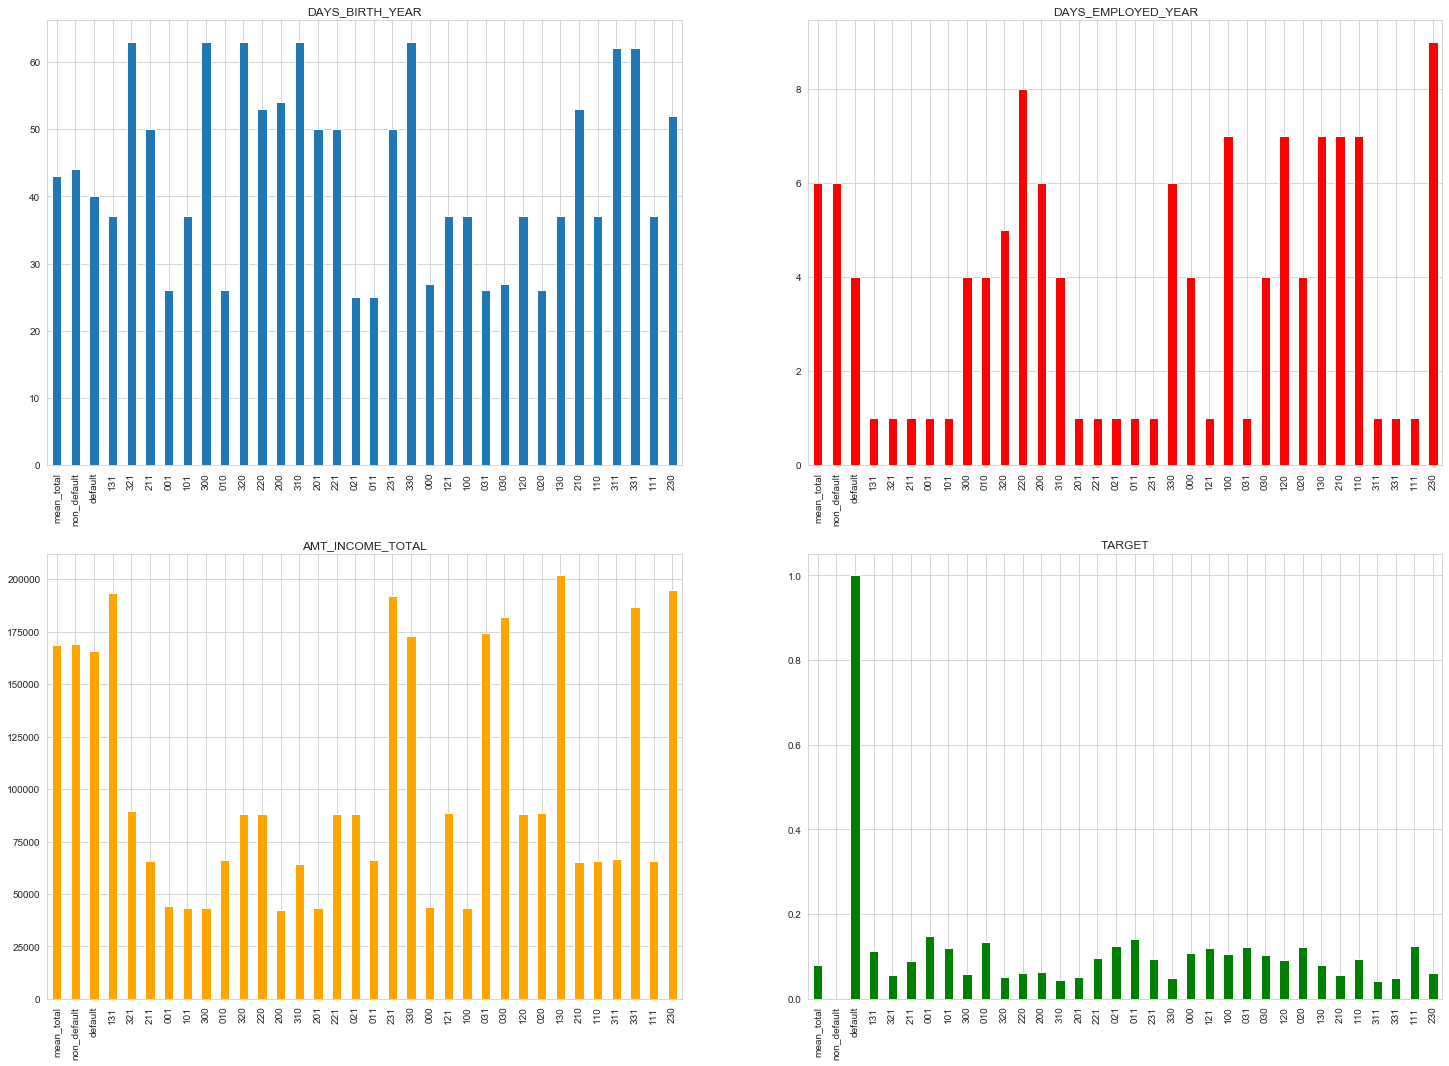

In [721]:
fig = plt.figure(figsize=(25,18))

ax = fig.add_subplot(221)
reference4['DAYS_BIRTH_YEAR'].plot(kind = 'bar')
plt.title('DAYS_BIRTH_YEAR')

ax = fig.add_subplot(222)
reference4['DAYS_EMPLOYED_YEAR'].plot(kind = 'bar', color = 'r')
plt.title('DAYS_EMPLOYED_YEAR')

ax = fig.add_subplot(223)
reference4['AMT_INCOME_TOTAL'].plot(kind='bar', color = 'orange')
plt.title('AMT_INCOME_TOTAL')

ax = fig.add_subplot(224)
reference4['TARGET'].plot(kind='bar', color = 'g')
plt.title('TARGET')

## graphes comparaison groupe de clients similaires

In [719]:
def graph_ref(simil):
    """trace les barplots des DAYS_BIRTH, DAYS_EMPLOYED, AMT_INCOME_TOTAL et TARGET 
    pour le cluster spécifié simil"""
    
    fig = plt.figure(figsize=(25,18))

    ax = fig.add_subplot(221)
    reference4['DAYS_BIRTH_YEAR'][['mean_total','non_default','default',simil]].plot(kind = 'bar')
    plt.title('DAYS_BIRTH_YEAR', fontsize = 18)
    plt.xticks(fontsize = 14, rotation = 'horizontal')
    plt.yticks(fontsize = 14)

    ax = fig.add_subplot(222)
    reference4['DAYS_EMPLOYED_YEAR'][['mean_total','non_default','default',simil]].plot(kind = 'bar', color = 'r')
    plt.title('DAYS_EMPLOYED_YEAR', fontsize = 18)
    plt.xticks(fontsize = 14, rotation = 'horizontal')
    plt.yticks(fontsize = 14)

    ax = fig.add_subplot(223)
    reference4['AMT_INCOME_TOTAL'][['mean_total','non_default','default',simil]].plot(kind='bar', color = 'orange')
    plt.title('AMT_INCOME_TOTAL', fontsize = 18)
    plt.xticks(fontsize = 14, rotation = 'horizontal')
    plt.yticks(fontsize = 14)

    ax = fig.add_subplot(224)
    reference4['TARGET'][['mean_total','non_default','default',simil]].plot(kind='bar', color = 'g')
    plt.title('TARGET', fontsize = 18)
    plt.xticks(fontsize = 14, rotation = 'horizontal')
    plt.yticks(fontsize = 14)

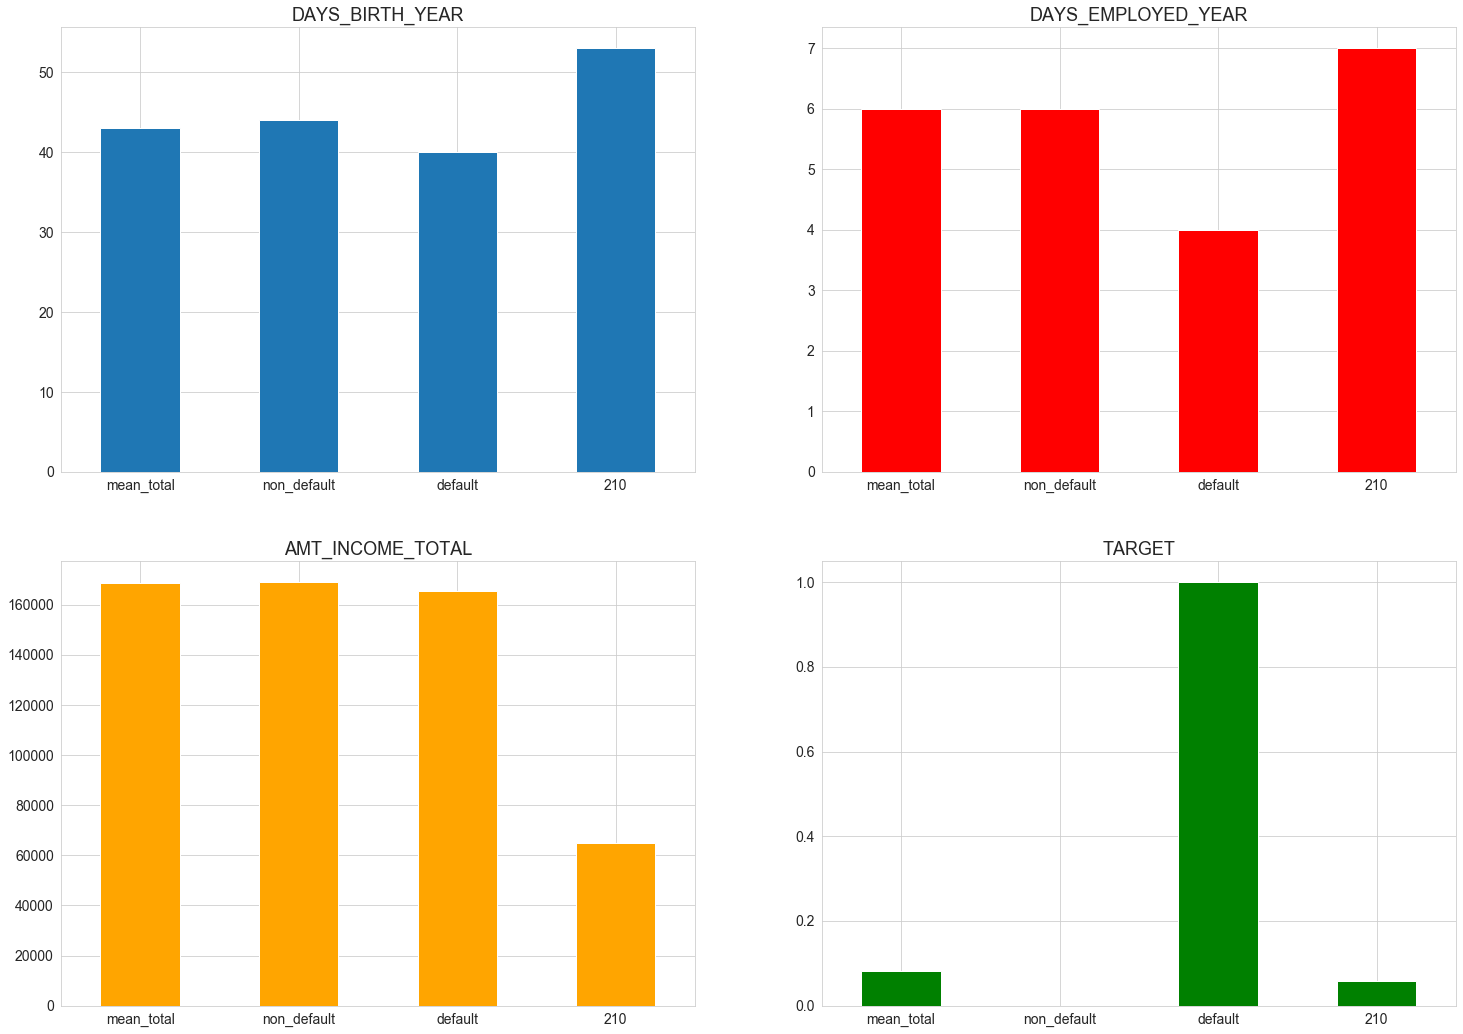

In [720]:
graph_ref('210')